In [2]:
import sys
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import plotly_express as px
import os
from typing import Union
from datetime import datetime, timedelta
import pandas as pd

from omegaconf import OmegaConf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.stats import zscore
cwd = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(cwd))
sys.path.append(parent_dir)

from src.data_management import get_data_by_dates, get_data_by_date_list
from src.scripts.research import create_model_decision_grid
from scipy.interpolate import griddata
from sklearn.preprocessing import LabelEncoder

from src.util import de_flatten_config, get_config
from src.scripts.testing import create_date_intervals

In [3]:
# Crossing the spread

df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_full.csv")
max_diff = 0.0001 * 10
decimals = 4
df['bid_actual'] = df.mid_price + np.round(df.bid * max_diff, decimals)
df['ask_actual'] = df.mid_price + np.round(df.ask * max_diff, decimals)
order_df = df[['bid_actual',"bid", 'ask_actual',"ask", "mid_price", "bid_size", "ask_size"]]
order_df['bid_limit'] = (order_df.bid < 0) & (order_df.bid_size != 0)
order_df['ask_limit'] = (order_df.ask > 0) & (order_df.ask_size != 0)


bid_limit = order_df['bid_limit'].sum()
ask_limit = order_df['ask_limit'].sum()
total_limit = bid_limit + ask_limit
total_orders = len(order_df) * 2
print(f"limit bid: {bid_limit}, limit ask {ask_limit}, total limit {total_limit}, total orders {total_orders}, limit ratio {total_limit / total_orders}")
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

limit bid: 5754471, limit ask 239561, total limit 5994032, total orders 11509158, limit ratio 0.5208054316397429


/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_33025/728562430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_df['bid_limit'] = (order_df.bid < 0) & (order_df.bid_size != 0)
/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_33025/728562430.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_df['ask_limit'] = (order_df.ask > 0) & (order_df.ask_size != 0)


NameError: name 'visual_folder' is not defined

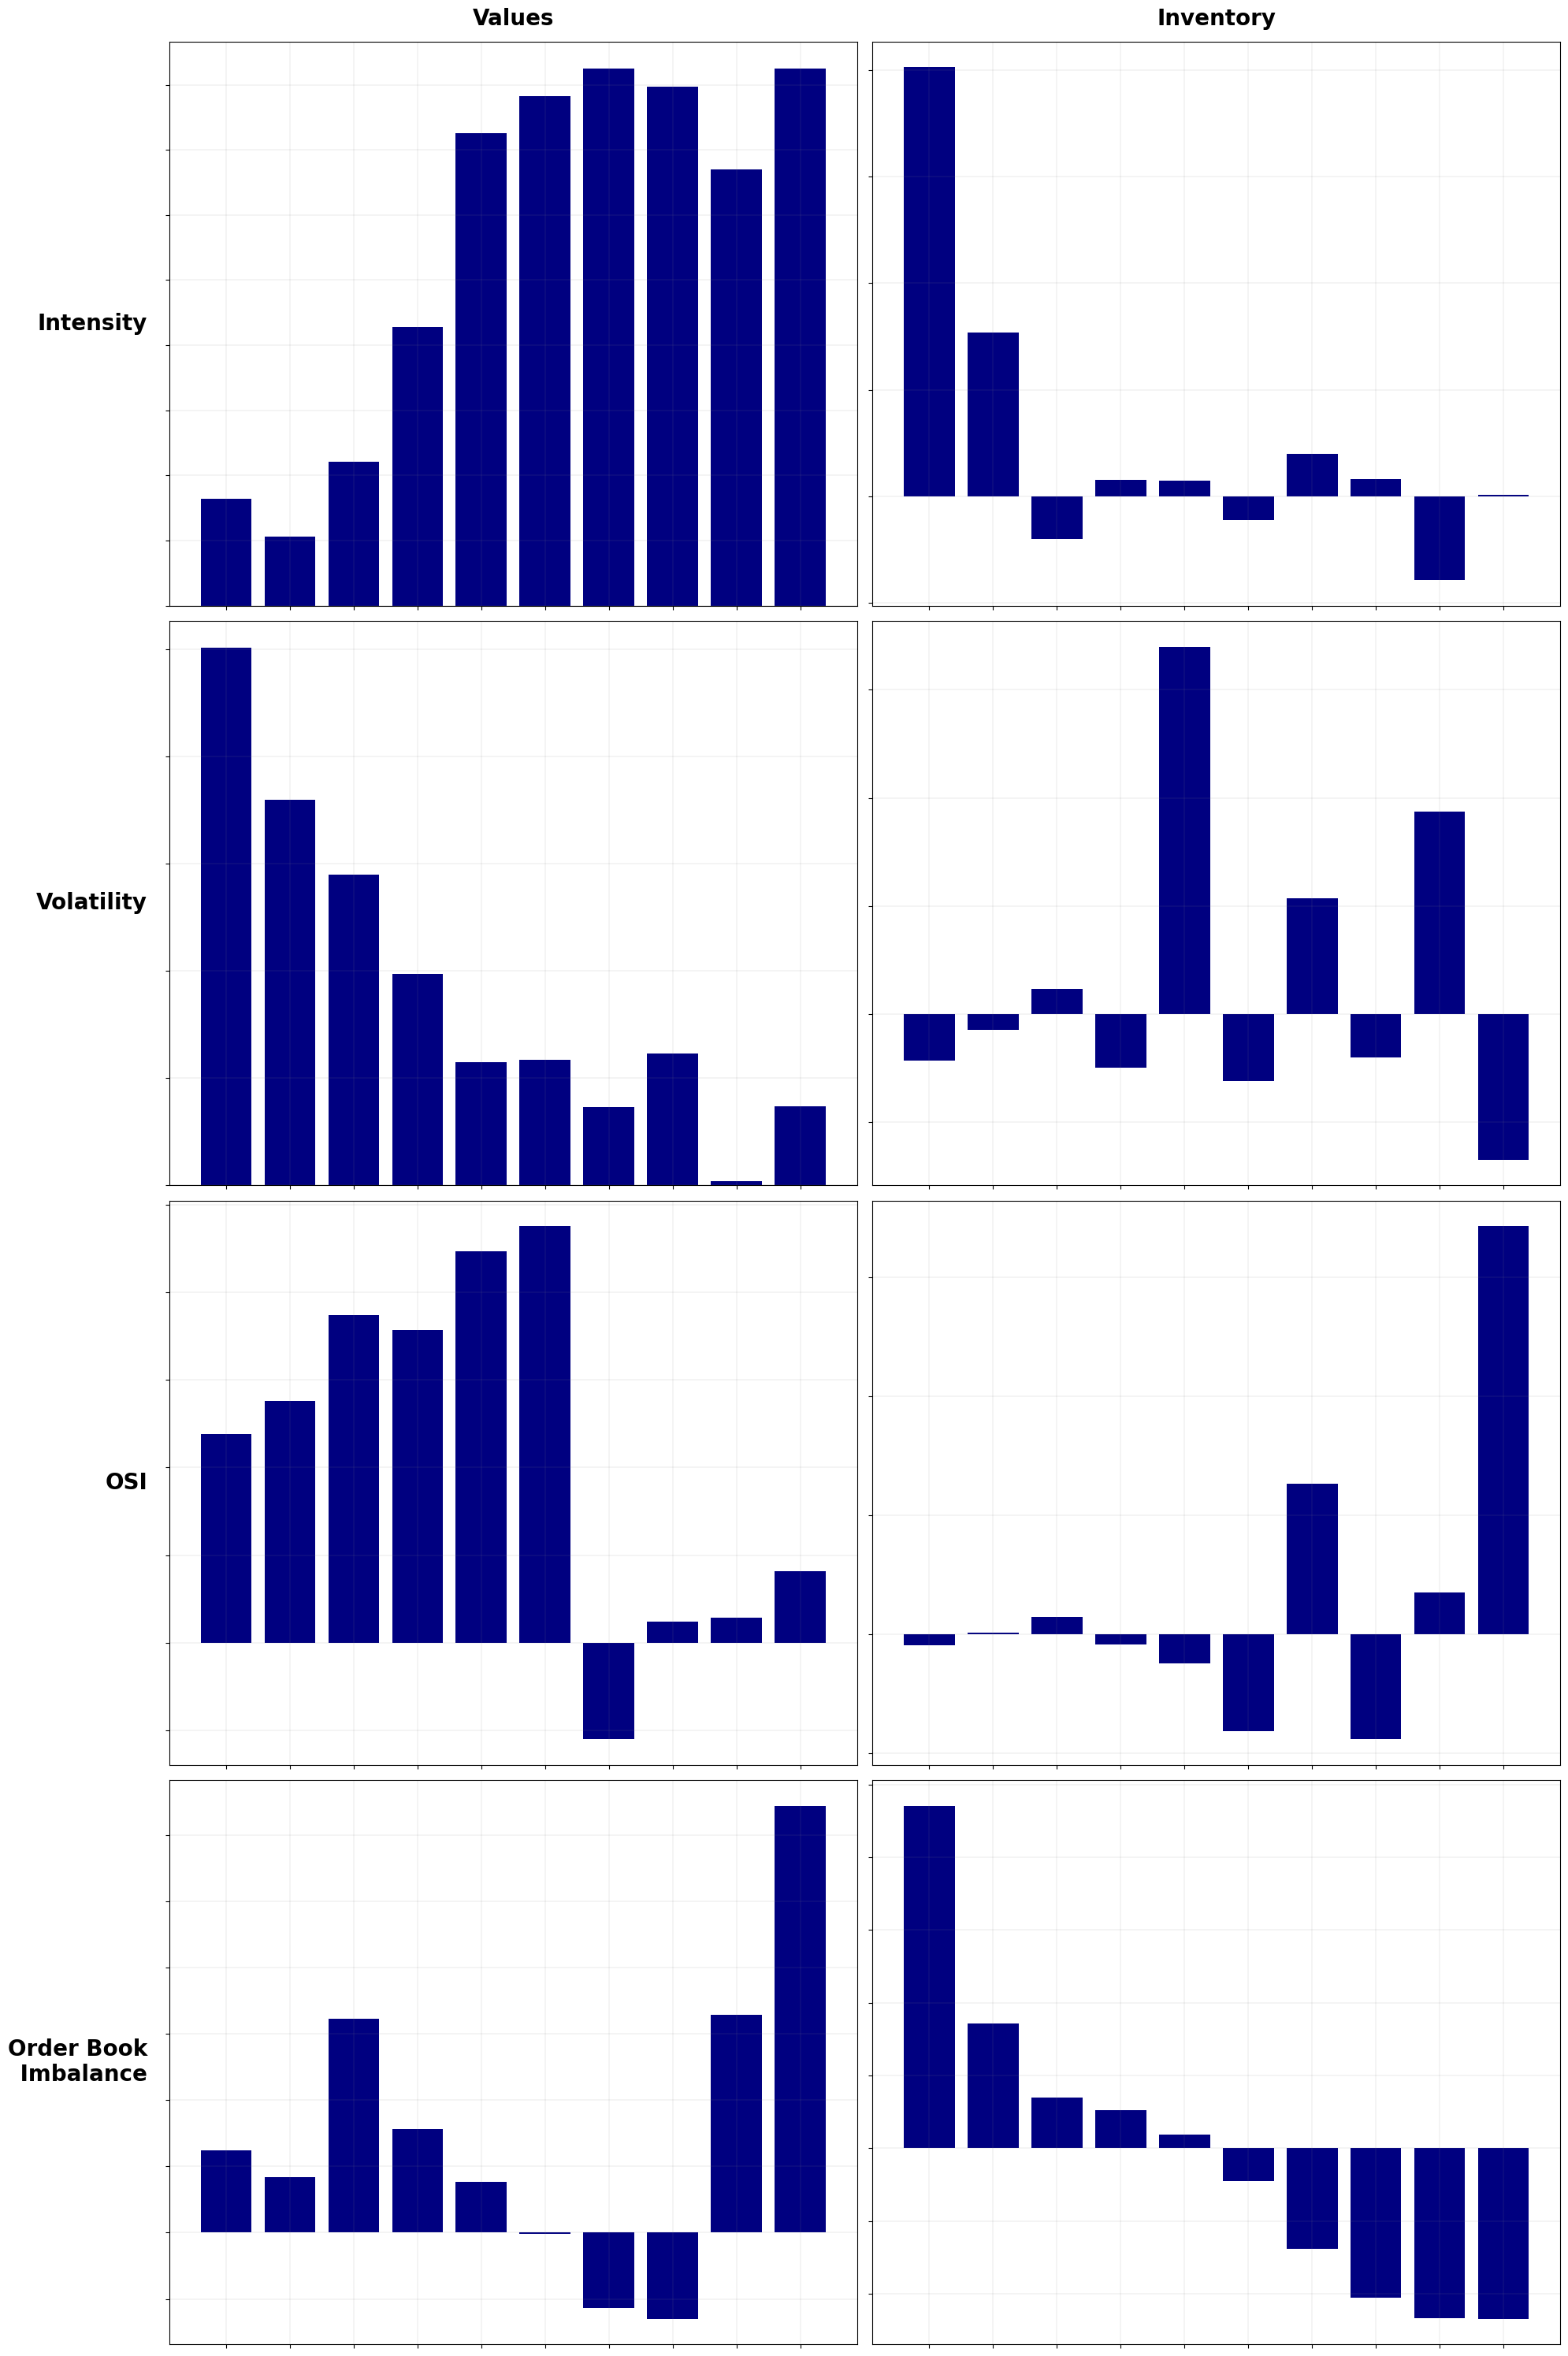

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # 4 rows and 2 columns

variables = ["intensity", "volatility", "osi", "order_book_imbalance"]
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

for i, var in enumerate(variables):
    for j, col in enumerate(["values", "inventory"]):
        df_copy = df.copy()
        df_copy[f'{var}_bins'] = pd.cut(df_copy[var], bins=10)
        df_copy['value_change'] = df_copy[col].diff()
        binned_value_change_sum = df_copy.groupby(f'{var}_bins')['value_change'].mean()
        
        axs[i, j].bar(binned_value_change_sum.index.astype(str), binned_value_change_sum, color='navy')  # Changed color to 'navy'
        axs[i, j].grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)  # Change gridline style
        axs[i, j].set_xticklabels([])  # Remove x-axis values
        axs[i, j].set_yticklabels([])  # Remove y-axis values

# fontfamily = 'serif'  # Set the font family
fontsize = 20  # Set the font size

for ax, col in zip(axs[0], ['Values', 'Inventory']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                size=fontsize, 
                # fontfamily=fontfamily,
                weight="bold", ha='center', va='baseline')  # Increased font size

for ax, row in zip(axs[:,0], titles):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=fontsize, 
                # fontfamily=fontfamily,
                weight="bold", ha='right', va='center')  # Increased font size

fig.tight_layout()
# plt.savefig(os.path.join(visual_folder, 'inventory_change_by_variables.png'))
plt.show()

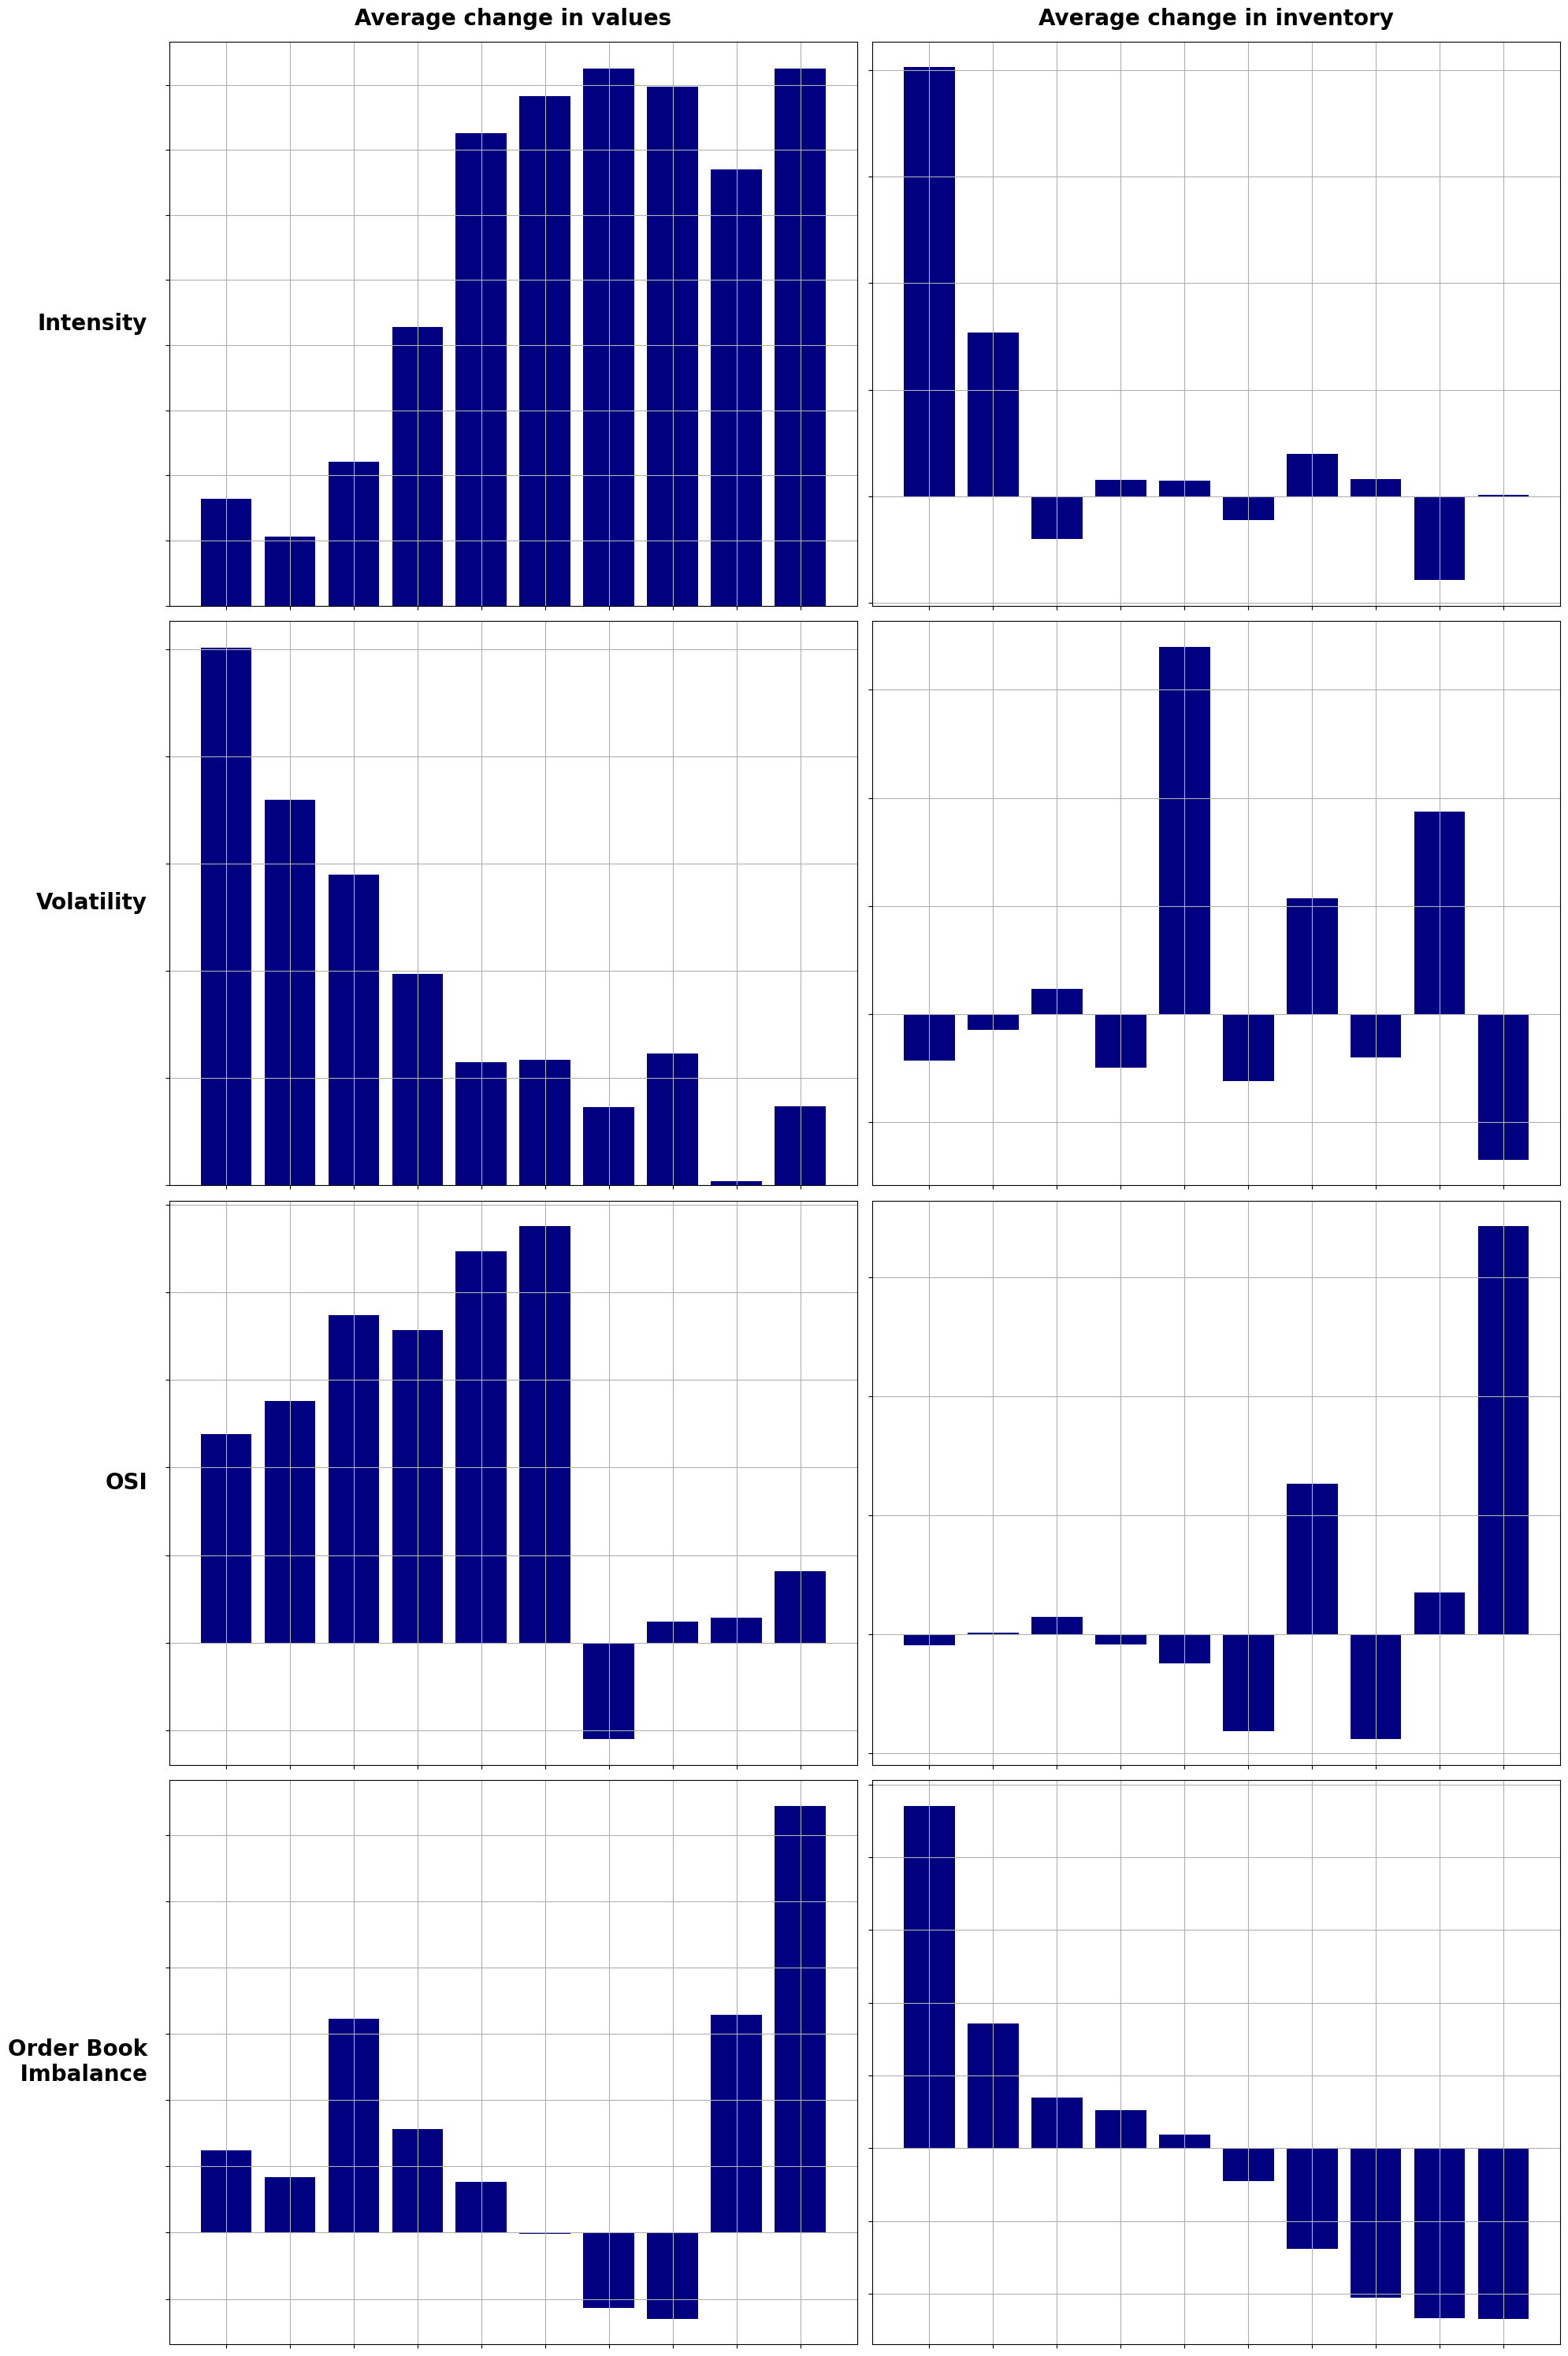

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # 4 rows and 3 columns

variables = ["intensity", "volatility", "osi", "order_book_imbalance"]
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

df_copy = df.copy()

for i, var in enumerate(variables):
    for j, col in enumerate(["values", "inventory"]):
        df_copy[f'{var}_bins'] = pd.cut(df_copy[var], bins=10)
        df_copy['value_change'] = df_copy[col].diff()
        df_copy['count'] = 1

        binned_value_change_mean = df_copy.groupby(f'{var}_bins')['value_change'].mean()
        binned_value_change_count = df_copy.groupby(f'{var}_bins')['count'].sum()
        axs[i, j].bar(binned_value_change_mean.index.astype(str), binned_value_change_mean, color='navy')  # Changed color to 'navy'
        axs[i, j].grid(True)
        axs[i, j].set_xticklabels([])  # Remove x-axis values
        axs[i, j].set_yticklabels([])  # Remove y-axis values


fontsize = 20  # Set the font size

for ax, col in zip(axs[0], ['Average change in values', 'Average change in inventory', 'Count of observations per bucket']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                size=fontsize, 
                weight="bold", ha='center', va='baseline')  # Increased font size

for ax, row in zip(axs[:,0], titles):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=fontsize, 
                weight="bold", ha='right', va='center')  # Increased font size

fig.tight_layout()
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_variables_not_scaled.png'))
plt.show()


In [4]:
df_copy = df.copy()
variables = ["values", "inventory"]

df_copy['intensity_bins'] = pd.cut(df_copy['intensity'], bins=10)
df_copy['inventory_bins'] = pd.cut(df_copy['inventory'], bins=10)

variable_change = [f"{i}_change" for i in variables]
df_copy['values_change'] = df_copy['values'].diff()
df_copy['inventory_change'] = df_copy['inventory'].diff()
df_copy[variable_change]

explanatory = ["intensity", "volatility", "osi", "order_book_imbalance"]

for i in explanatory:
    df_copy[f"{i}_bins"], _ = pd.factorize(pd.cut(df_copy[i], bins=10))


df_copy[["values_change"] + [f"{i}_bins" for i in explanatory]]
values_change_df = df_copy[["values_change"] + [f"{i}_bins" for i in explanatory]].copy()
inventory_change_df = df_copy[["inventory_change"] + [f"{i}_bins" for i in explanatory]].copy()


total_values_df = pd.DataFrame()
count_values_df = pd.DataFrame()
for i in explanatory:
    values_change_df[f'{i}_bins'] = values_change_df[f'{i}_bins'].astype(str)    
    total_values_df[i] = values_change_df[[f"{i}_bins", "values_change"]].groupby(f"{i}_bins").sum()['values_change']
    count_values_df[i] = values_change_df[[f"{i}_bins", "values_change"]].groupby(f"{i}_bins").count()['values_change']


total_inventory_df = pd.DataFrame()
count_inventory_df = pd.DataFrame()
for i in explanatory:
    inventory_change_df[f'{i}_bins'] = inventory_change_df[f'{i}_bins'].astype(str)    
    total_inventory_df[i] = inventory_change_df[[f"{i}_bins", "inventory_change"]].groupby(f"{i}_bins").sum()['inventory_change']


total_values_df.rename_axis(index="bins", inplace=True)
total_inventory_df.rename_axis(index="bins", inplace=True)
count_values_df.rename_axis(index="bins", inplace=True)



cols = list(total_values_df.columns)
fig, axs = plt.subplots(len(cols), 3, figsize=(25, 15))

colors = ['#082567', '#0F52BA', '#1565C0', '#1E88E5']
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

values_max = total_values_df.max().max()
values_min = total_values_df.min().min()
inventory_max = total_inventory_df.max().max()
inventory_min = total_inventory_df.min().min()
count_max = count_values_df.max().max()
count_min = count_values_df.min().min()

# Column headers
col_titles = ['Total change in value', 'Total change in inventory', 'Count of observations per bucket']

# Set column titles
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col, fontsize=20)

# Set row labels
for ax, row in zip(axs[:,0], titles):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=50)

for count, i in enumerate(cols):
    total_values = total_values_df[i]
    total_inventory = total_inventory_df[i]
    count_df = count_values_df[i]

    # Remove x-axis label
    if count < len(cols) - 1:  # If it's not the last row
        axs[count, 0].set_xticklabels([])
        axs[count, 1].set_xticklabels([])
        axs[count, 2].set_xticklabels([])

    total_values.plot(kind='bar', ax=axs[count, 0], color="navy")
    axs[count, 0].grid(True)
    axs[count, 0].set_ylim([values_min, values_max])  # Set common y-axis limits

    total_inventory.plot(kind='bar', ax=axs[count, 1], color="navy")
    axs[count, 1].grid(True)
    axs[count, 1].set_ylim([inventory_min, inventory_max])  # Set common y-axis limits

    count_df.plot(kind='bar', ax=axs[count, 2], color="navy")
    axs[count, 2].grid(True)
    axs[count, 2].set_ylim([count_min, count_max])  # Set common y-axis limits

fig.tight_layout()
plt.show()


NameError: name 'average_values_df' is not defined

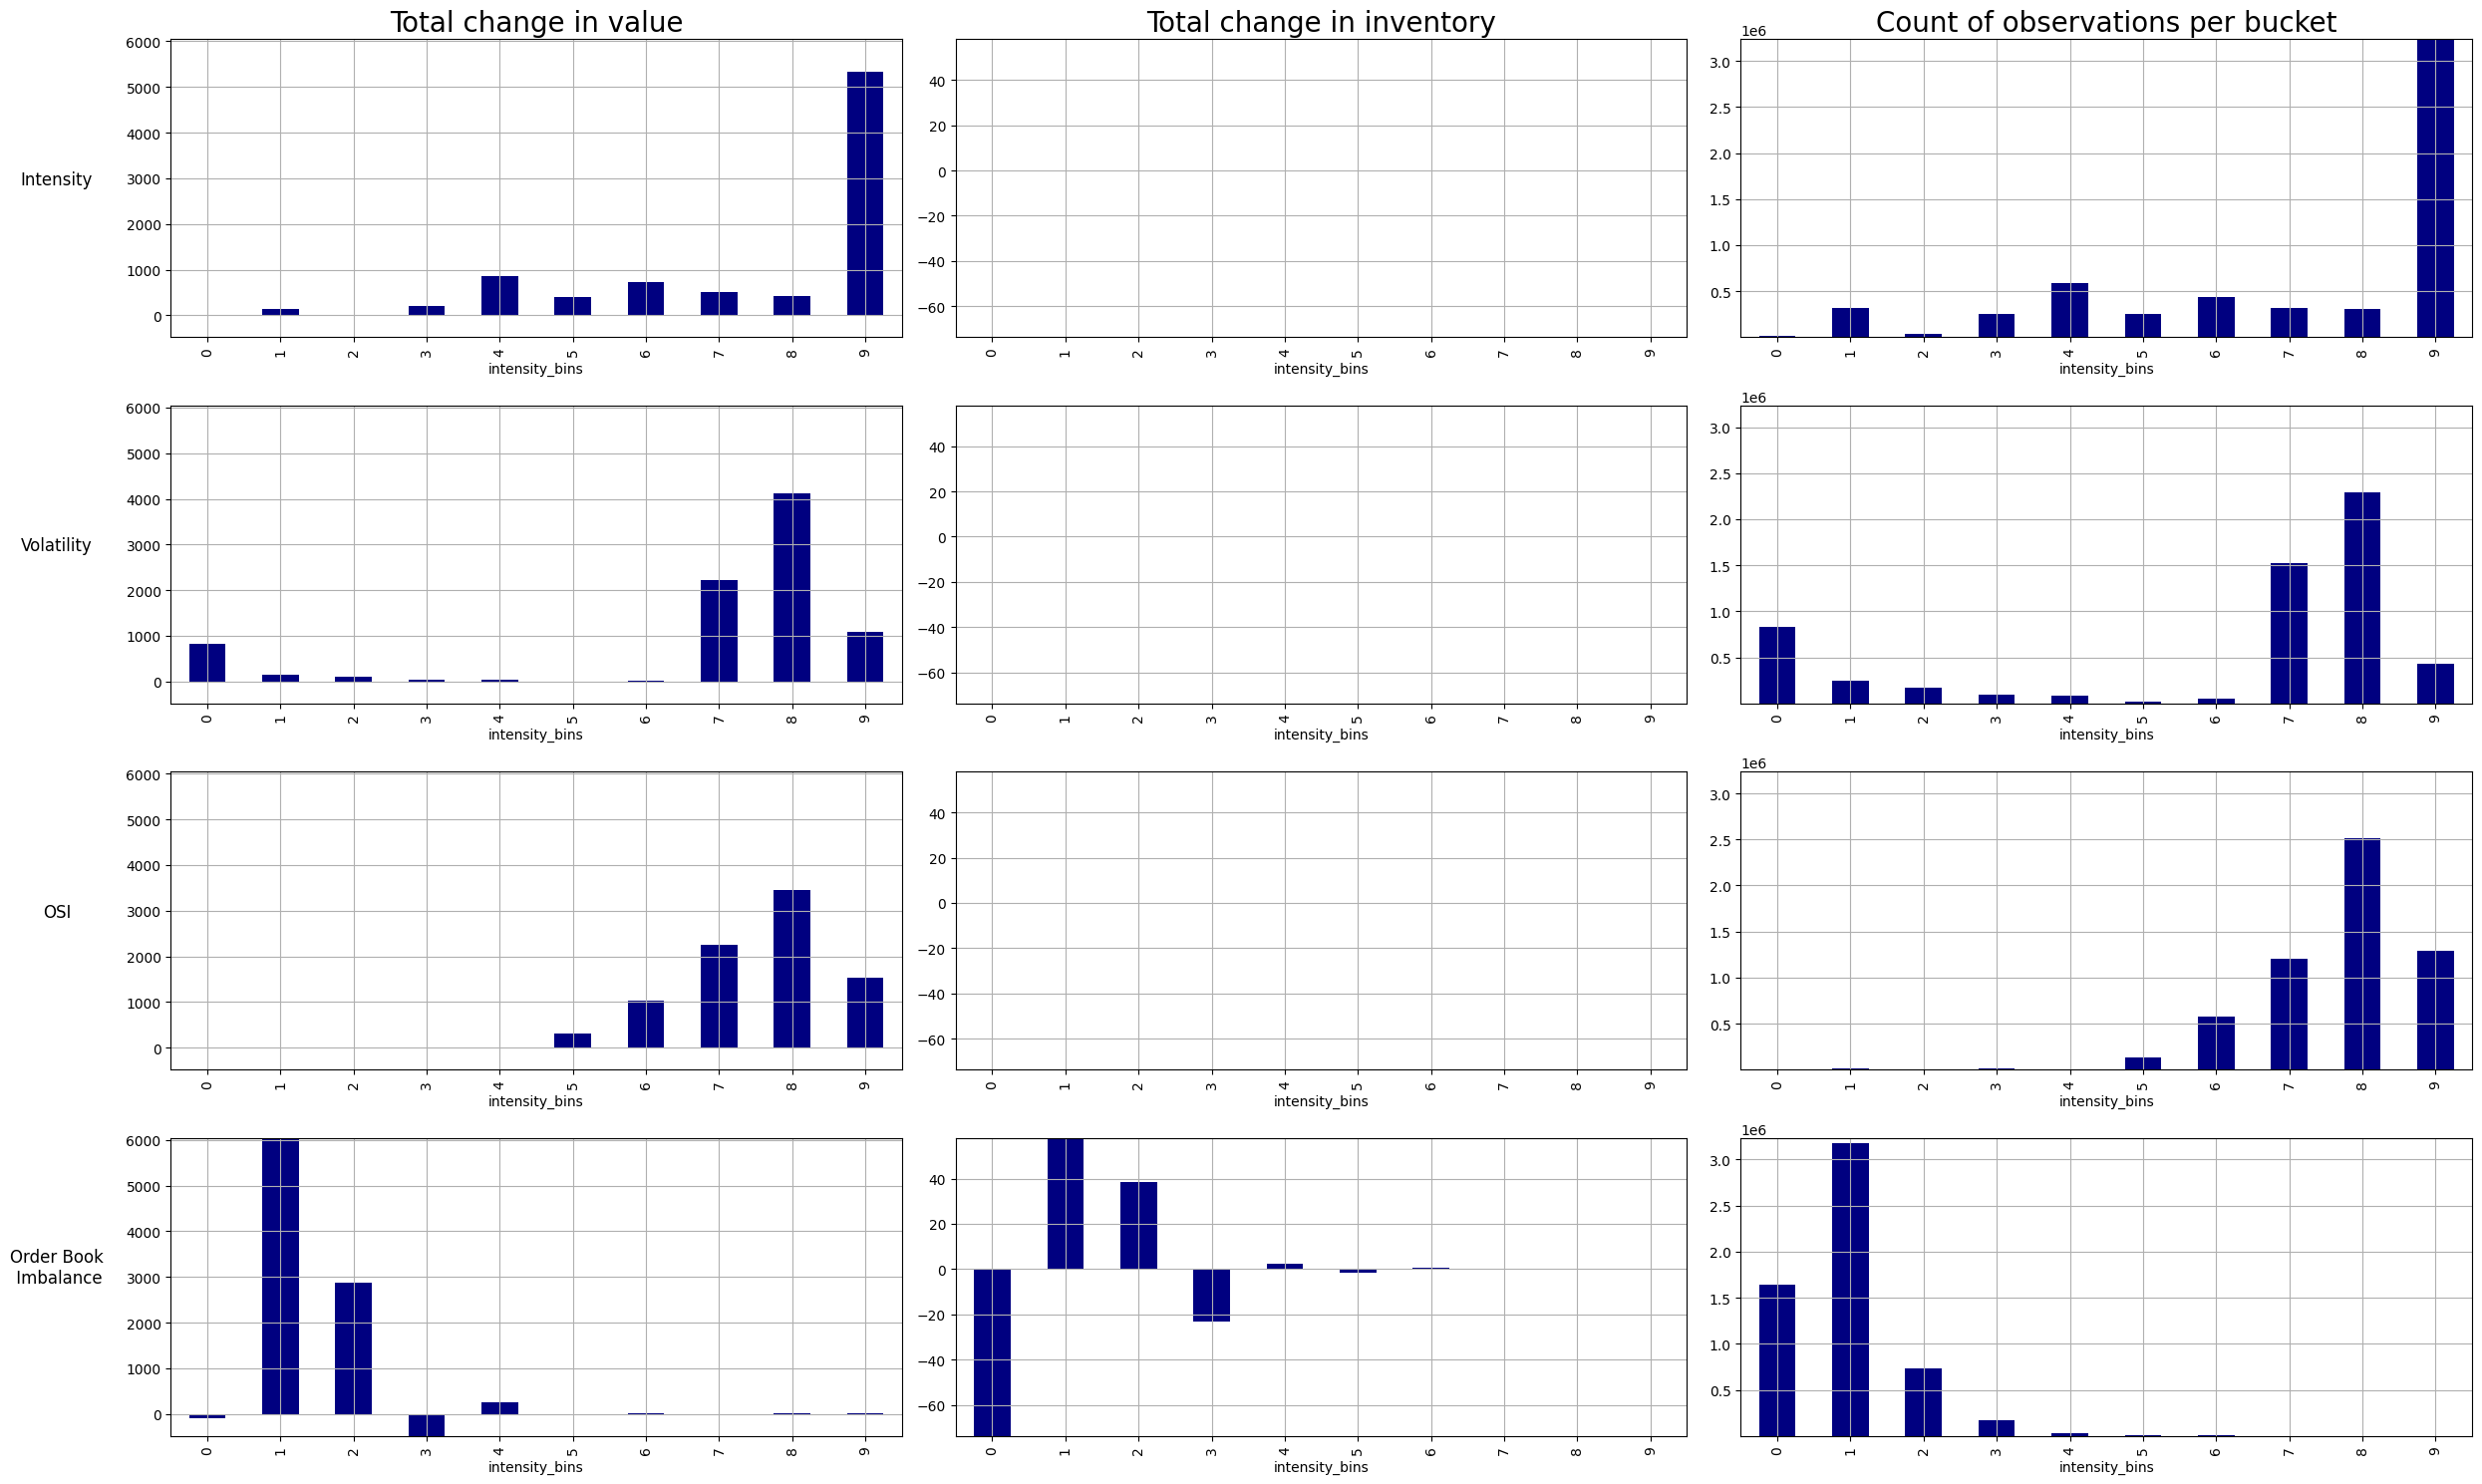

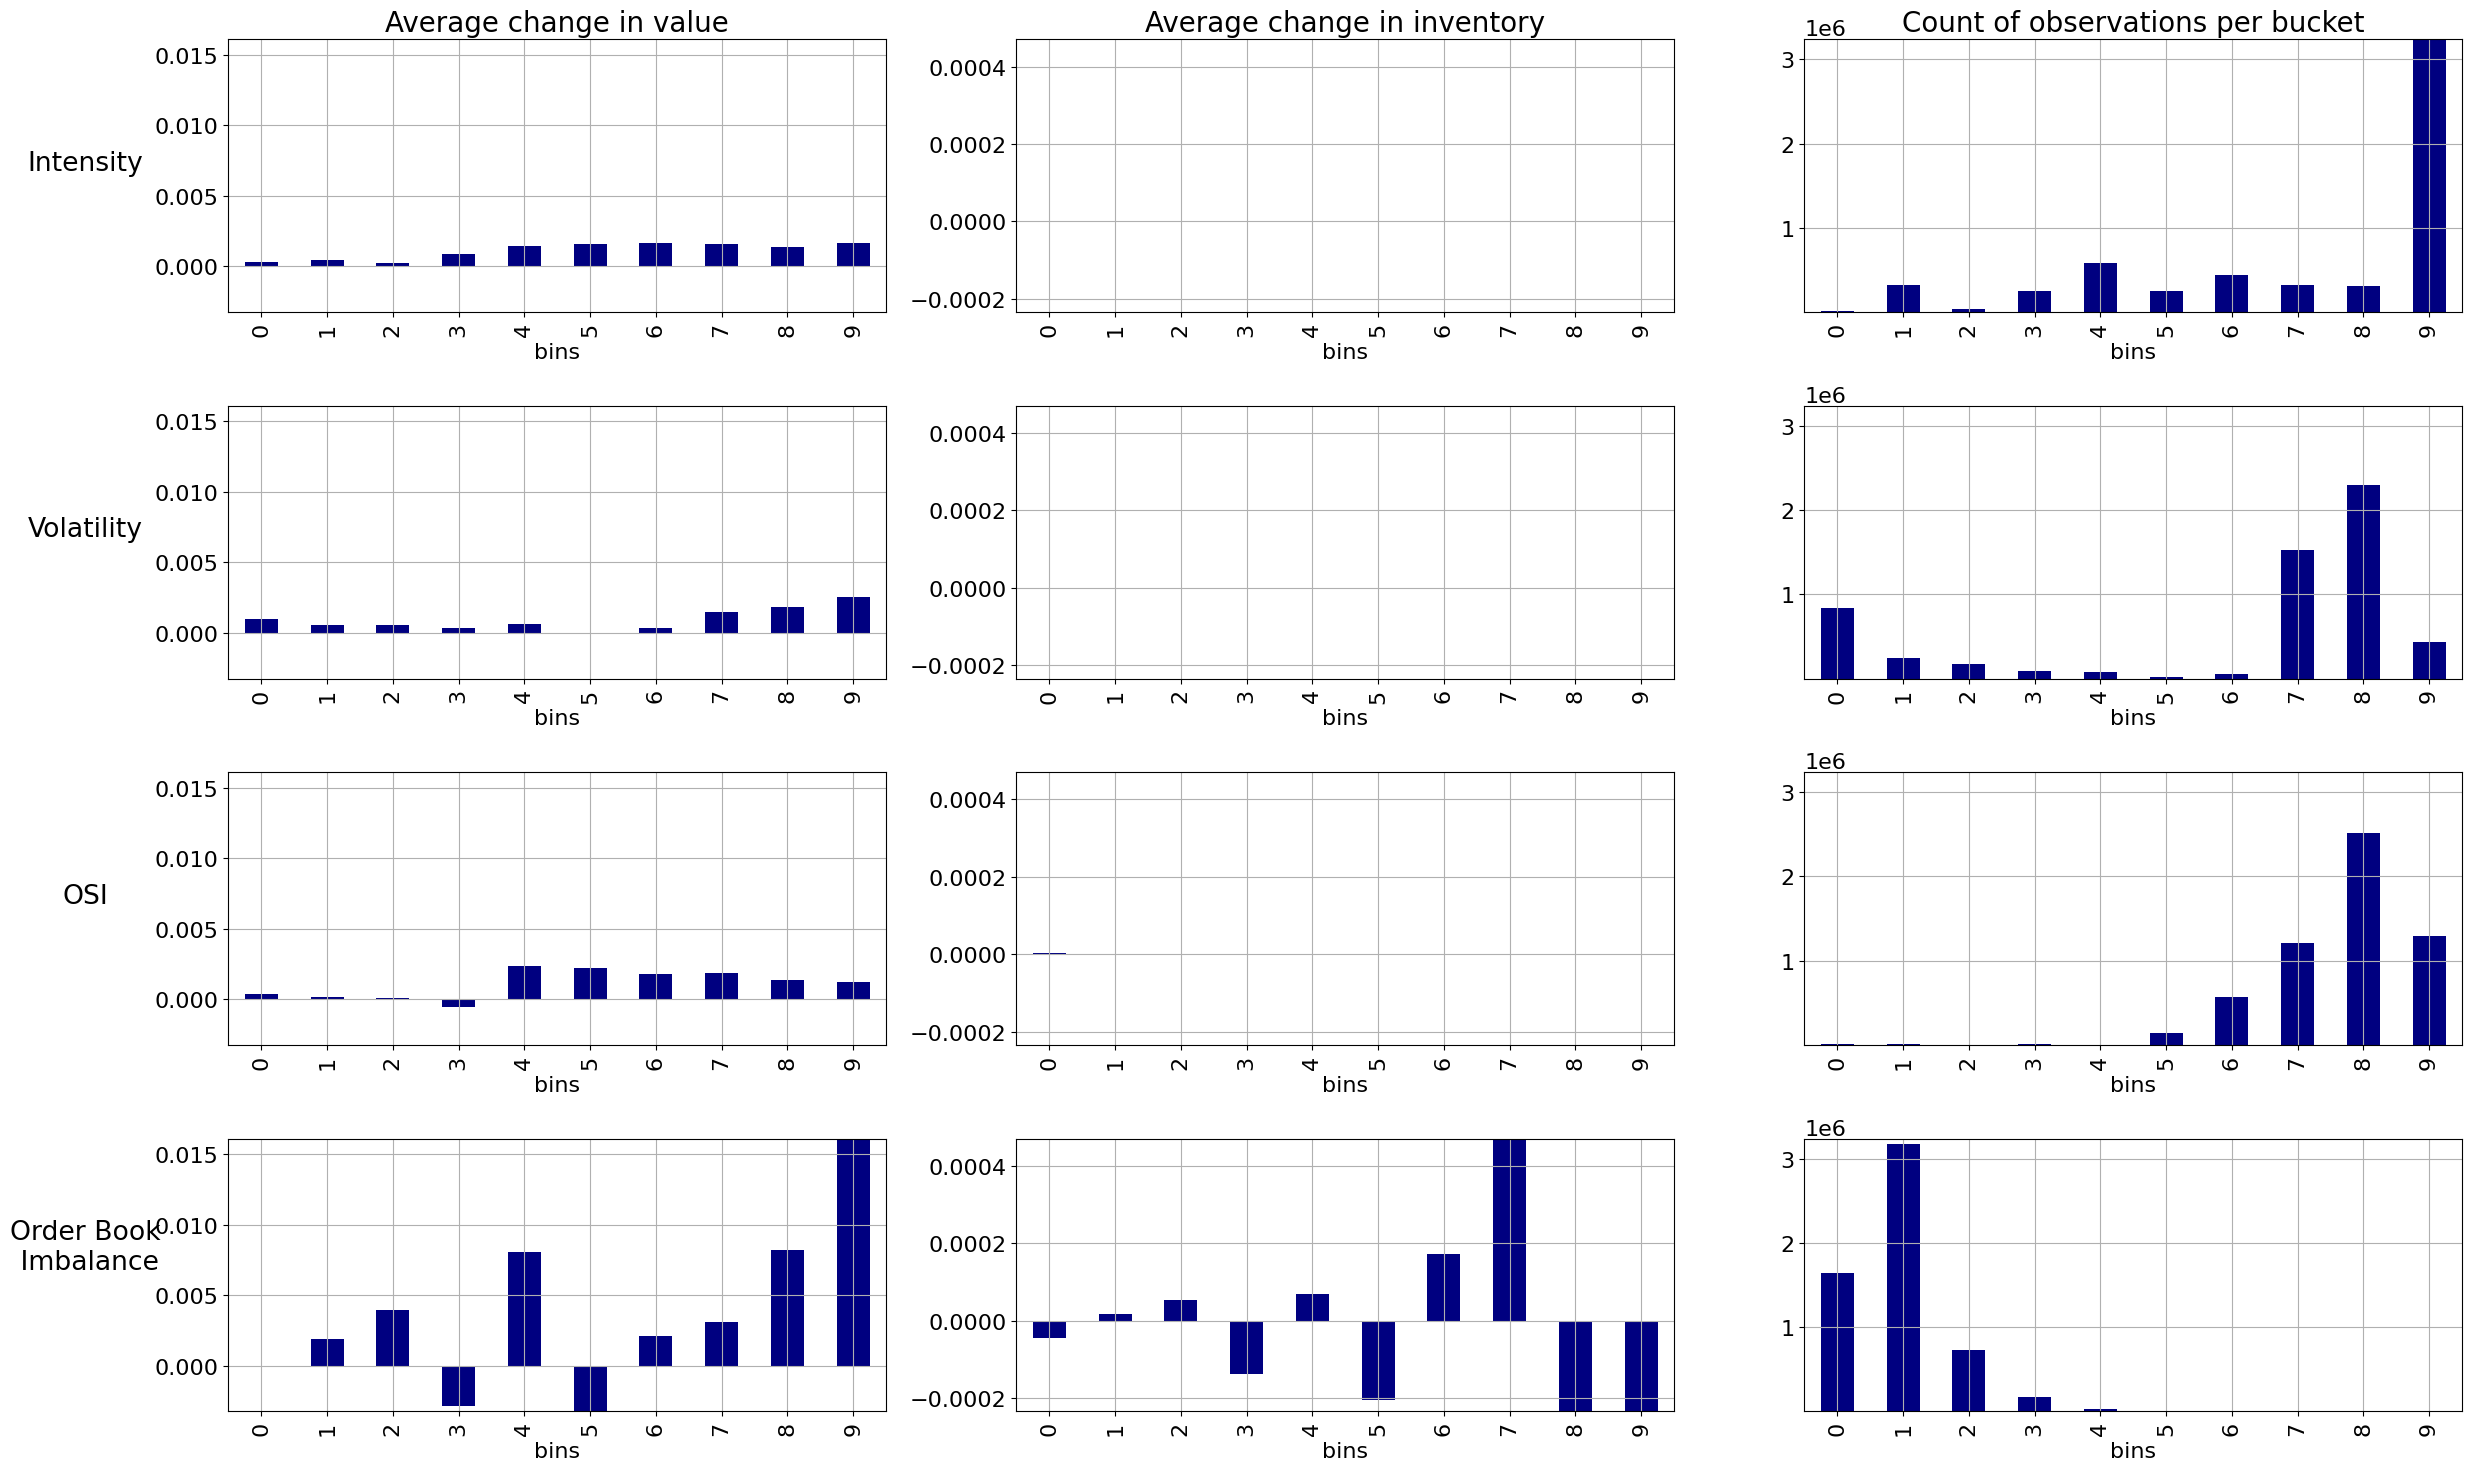

In [200]:
cols = list(average_values_df.columns)
fig, axs = plt.subplots(len(cols), 3, figsize=(25, 15))

colors = ['#082567', '#0F52BA', '#1565C0', '#1E88E5']
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

values_max = average_values_df.max().max()
values_min = average_values_df.min().min()
inventory_max = average_inventory_df.max().max()
inventory_min = average_inventory_df.min().min()
count_max = count_values_df.max().max()
count_min = count_values_df.min().min()

# Column headers
col_titles = ['Average change in value', 'Average change in inventory', 'Count of observations per bucket']

# Set column titles
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col, fontsize=20)

# Set row labels
for ax, row in zip(axs[:,0], titles):
    ax.set_ylabel(row, rotation=0, size='large', labelpad=50)

for count, i in enumerate(cols):
    average_values = average_values_df[i]
    average_inventory = average_inventory_df[i]
    count_df = count_values_df[i]

    # Remove x-axis label
    if count < len(cols) - 1:  # If it's not the last row
        axs[count, 0].set_xticklabels([])
        axs[count, 1].set_xticklabels([])
        axs[count, 2].set_xticklabels([])

    average_values.plot(kind='bar', ax=axs[count, 0], color="navy")
    axs[count, 0].grid(True)
    axs[count, 0].set_ylim([values_min, values_max])  # Set common y-axis limits

    average_inventory.plot(kind='bar', ax=axs[count, 1], color="navy")
    axs[count, 1].grid(True)
    axs[count, 1].set_ylim([inventory_min, inventory_max])  # Set common y-axis limits

    count_df.plot(kind='bar', ax=axs[count, 2], color="navy")
    axs[count, 2].grid(True)
    axs[count, 2].set_ylim([count_min, count_max])  # Set common y-axis limits

fig.tight_layout()
plt.show()


In [91]:
config = get_config('base_rolling_train_test')
# create_date_intervals(config.rolling_test_train.start_date,
#                       config.rolling_test_train.end_date,
#                       0,
#                       config.rolling_test_train.skipped_days)
start_date = datetime.strptime(config.rolling_test_train.start_date, "%Y_%m_%d")
end_date = datetime.strptime(config.rolling_test_train.end_date, "%Y_%m_%d")
interval = 0
skipped = config.rolling_test_train.skipped_days
skipped_dates = [datetime.strptime(date, "%Y_%m_%d") for date in skipped]

date_ranges = create_date_intervals(start_date, end_date, interval, skipped_dates)
raw_data = get_data_by_date_list(date_ranges).reset_index(drop=True)

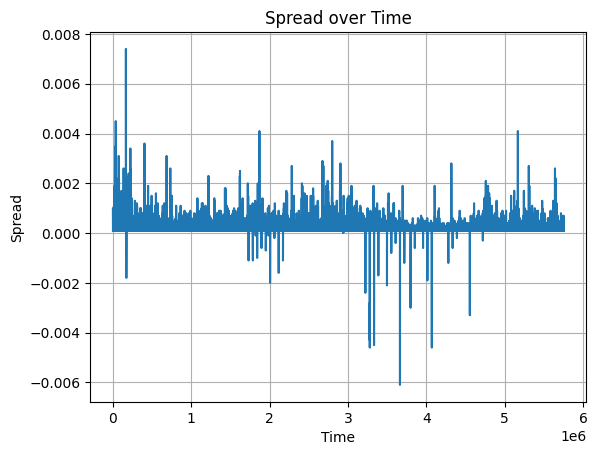

count    5.754579e+06
mean     1.024290e-04
std      8.133647e-05
min     -6.100000e-03
25%      1.000000e-04
50%      1.000000e-04
75%      1.000000e-04
max      7.400000e-03
dtype: float64

In [93]:
spread = raw_data['best_ask'] - raw_data['best_bid']

plt.plot(spread)
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Spread over Time')
plt.grid(True)
plt.show()
spread.describe()


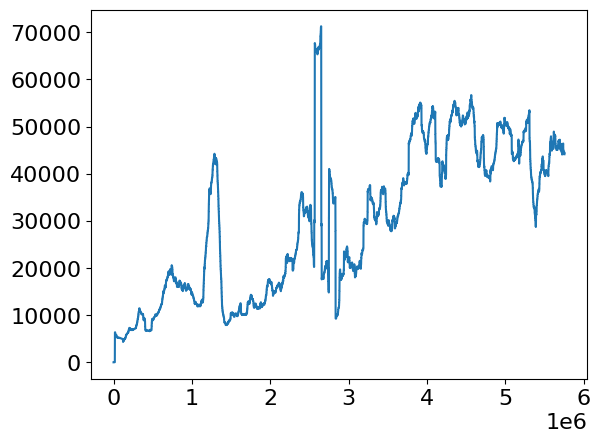

In [143]:
plt.plot(raw_data[["intensity"]])

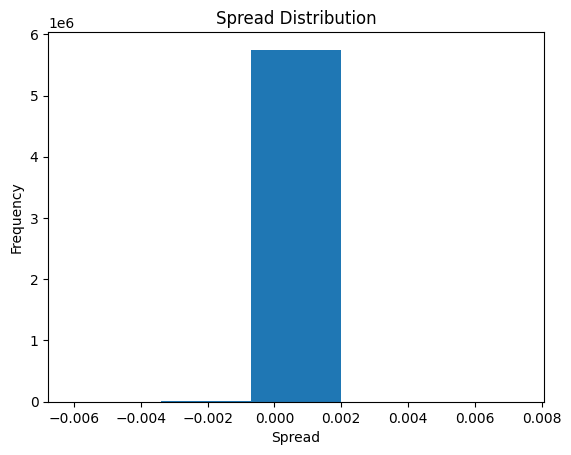

In [94]:
# Divide the spread into 5 buckets
num_bins = 5

# Plot the histogram
plt.hist(spread, bins=num_bins)

plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.title('Spread Distribution')

plt.show()

In [178]:
# Raw data examinat

start_date= "2021_12_21"
as_dt = datetime.strptime(start_date, "%Y_%m_%d")
val_dict = {
    "date":[], # "2021_12_21
    "min_intensity":[],
    "max_intensity":[],
    "min_volatility":[],
    "max_volatility":[],
    "low_spread":[],
    "high_spread":[],

}
while True:
    try:
        df = get_data_by_dates(as_dt)
        val_dict["date"].append(as_dt.strftime("%Y_%m_%d"))
        val_dict["min_intensity"].append(df["intensity"].min())
        val_dict["max_intensity"].append(df["intensity"].max())
        val_dict["min_volatility"].append(df["volatility"].min())
        val_dict["max_volatility"].append(df["volatility"].max())
        
        df.replace({0: np.nan}, inplace=True)
        df['low_spread'] = df.mid_price - df.low_price
        df['high_spread'] = df.high_price - df.mid_price


        val_dict["low_spread"].append(df["low_spread"].median())
        val_dict["high_spread"].append(df["high_spread"].median())

        as_dt += timedelta(days=1)
    except Exception as e:
        print(e)
        break
df = pd.DataFrame(val_dict)
df[(df.min_intensity < 100)].date.tolist()


Error reading file: [Errno 2] No such file or directory: '/Volumes/ssd/gradu_data/parsed/2022_04_06/data.csv'


['2022_01_11',
 '2022_01_12',
 '2022_01_13',
 '2022_01_14',
 '2022_01_15',
 '2022_01_16',
 '2022_01_17',
 '2022_01_18',
 '2022_01_19',
 '2022_01_20',
 '2022_01_21',
 '2022_01_22']

In [183]:
# px.line(df, x='date', y=['min_intensity', 'max_intensity'])
# px.line(df, x='date', y=['min_volatility', 'max_volatility'])

df_removed = df[(np.abs(df.low_spread) < 0.0019)]
# df_removed = df.copy()
px.line(df_removed, x='date', y=['low_spread', 'high_spread'])

In [97]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_summary_run_trades.csv")

columns = ['trading_bid_ratio', "bid_limit_ratio", "bid_limit_hit_rate", "trading_ask_ratio", "ask_limit_ratio", "ask_limit_hit_rate"]
df['trading_bid_ratio'] = df.bid_trade_count / df.timesteps
df['bid_limit_ratio'] = df.bid_limit_count / df.bid_trade_count
# df['bid_market_ratio'] = df.bid_market_count / df.bid_trade_count
df['bid_limit_hit_rate'] = df.bid_limit_hit_count / df.bid_limit_count

df['trading_ask_ratio'] = df.ask_trade_count / df.timesteps
df['ask_limit_ratio'] = df.ask_limit_count / df.ask_trade_count
# df['ask_market_ratio'] = df.ask_market_count / df.ask_trade_count
df['ask_limit_hit_rate'] = df.ask_limit_hit_count / df.ask_limit_count
df['limit_hit_count'] = df.ask_limit_hit_count + df.bid_limit_hit_count
df["market_hit_count"] = (1 - df.bid_limit_ratio) * df.bid_trade_count + (1 - df.ask_limit_ratio) * df.ask_trade_count
df[columns + ['limit_hit_count', 'market_hit_count', "bid_limit_value", "ask_limit_value", "bid_market_value", "ask_market_value"]]


volume_col = ['bid_limit_volume', 'ask_limit_volume', 'bid_market_volume', 'ask_market_volume']
df[volume_col]

df['limit_volume'] = df.bid_limit_volume + df.ask_limit_volume
df['market_volume'] = df.bid_market_volume + df.ask_market_volume
df['total_volume'] = df.limit_volume + df.market_volume
df['limit_volume_ratio'] = df.limit_volume / df.total_volume
df['market_volume_ratio'] = df.market_volume / df.total_volume

df[['limit_volume_ratio', 'market_volume_ratio']]

df[['limit_hit_count', 'market_hit_count', 'limit_volume_ratio', 'market_volume_ratio']]

df[['bid_limit_ratio', "ask_limit_ratio"]]

,bid_limit_ratio,ask_limit_ratio
0,1.000000,0.002972
1,0.999809,0.027595
2,1.000000,0.008231
3,1.000000,0.038678
4,1.000000,0.010601
...,...,...
65,1.000000,0.127203
66,1.000000,0.071483
67,1.000000,0.066727
68,1.000000,0.086201


In [136]:
# SUMMARY Results

files = ["delta_inventory_pnlreward_1684931119_summary_run_trades.csv", "delta_inventory_pnlreward_1684931119_summary_run_trades_as_comparison=False.csv"]
rename_dict = {
    files[0]: "Model",
    files[1]: "Expert"}

full_df = pd.DataFrame()
for i in files:
    df = pd.read_csv(f"/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/{i}")
    df['type'] = rename_dict[i]
    if full_df.empty:
        full_df = df
    else:
        full_df = pd.concat([full_df, df])
    
full_df['date'] = pd.to_datetime(full_df['date'])
full_df = full_df[(full_df.date != "2022-03-10") & (full_df.date != "2022-03-29") & (full_df.date != "2022-03-02")]
full_df['bid_market_count'] = full_df.bid_trade_count - full_df.bid_limit_count
full_df['ask_market_count'] = full_df.ask_trade_count - full_df.ask_limit_count
px.line(full_df, x='date', y=['episode_return'], color="type")
px.line(full_df, x='date', y=['drawdown'], color="type")
px.line(full_df, x='date', y=['trades'], color="type")
px.line(full_df, x='date', y=['max_inventory'], color="type")
px.line(full_df, x='date', y=['mean_abs_inv'], color="type")


full_df['limit_volume'] = full_df.bid_limit_volume + full_df.ask_limit_volume
full_df['market_volume'] = full_df.bid_market_volume + full_df.ask_market_volume
full_df['total_volume'] = full_df.limit_volume + full_df.market_volume
full_df['limit_volume_ratio'] = full_df.limit_volume / full_df.total_volume

full_df['limit_volume_ratio']


px.line(full_df, x='date', y=['limit_volume_ratio'], color="type")
# px.line(full_df, x='date', y=['limit_trades'], color="type")
# px.line(full_df, x='date', y=['market_trades'], color="type")

# full_df.drop(columns=["date"]).groupby('type').sum()
full_df[['bid_limit_value', 'ask_limit_value', 'bid_market_value', 'ask_market_value']]
full_df['limit_value'] = full_df.bid_limit_value + full_df.ask_limit_value
full_df['market_value'] = full_df.bid_market_value + full_df.ask_market_value

px.line(full_df, x='date', y=['limit_value'], color="type")
px.line(full_df, x='date', y=['market_value'], color="type")



full_df.columns
# full_df.groupby('type').agg({
#     "bid_limit_hit_count": "mean",  # Average Daily Return
#     "ask_limit_hit_count": "mean",  # Average Max Drawdown & Max Drawdown
#     "total_trades": "mean",  # Average Trades per Day
#     "max_inventory": "max",  # Max Inventory
#     "mean_abs_inv": "mean"  # Mean Absolute Position
# })
# full_df.groupby("type").mean()[["bid_limit_hit_count", "ask_limit_hit_count", "bid_market_count", "ask_market_count"]]

full_df.groupby("type").mean()[["bid_limit_value", "ask_limit_value", "bid_market_value", "ask_market_value"]]



# full_df['bid_limit_share'] = full_df.bid_limit_count / full_df.bid_trade_count
# full_df['bid_market_share'] = full_df.bid_market_count / full_df.bid_trade_count
# full_df['ask_limit_share'] = full_df.ask_limit_count / full_df.ask_trade_count
# full_df['ask_market_share'] = full_df.ask_market_count / full_df.ask_trade_count

# full_df.groupby("type").mean()[["bid_trade_count", "bid_limit_share",  "bid_market_share", "ask_trade_count", "ask_limit_share", "ask_market_share"]]

full_df['bid_hit_ratio'] = full_df.bid_limit_hit_count / full_df.bid_limit_count
full_df['ask_hit_ratio'] = full_df.ask_limit_hit_count / full_df.ask_limit_count

full_df.groupby("type").mean()[["bid_hit_ratio", "ask_hit_ratio"]]


,bid_hit_ratio,ask_hit_ratio
type,,
Expert,0.287248,0.284448
Model,0.164571,0.390683


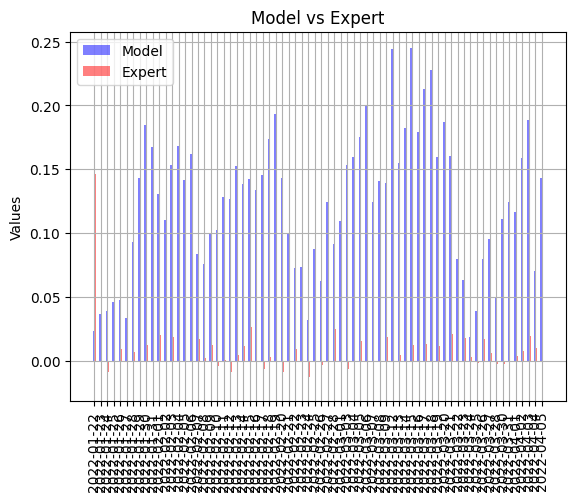

In [236]:
pos = list(range(len(df['Model']))) 
width = 0.25 
plt.bar(pos, df['Model'], width, alpha=0.5, color='b', label='Model') 

# Plotting the 'Expert' column in position pos + width
plt.bar([p + width for p in pos], df['Expert'], width, alpha=0.5, color='r', label='Expert') 

# Setting the y axis label
plt.ylabel('Values')

# Setting the chart's title
plt.title('Model vs Expert')

# Setting the position of the x ticks
plt.xticks([p + width/2 for p in pos], df['date'].dt.date, rotation=90)

# Adding the legend and showing the plot
plt.legend(['Model', 'Expert'], loc='upper left')
plt.grid()
plt.show()

In [55]:
a = np.array([True])
b = np.array([-0, 1, 2,3,0.5])
b.astype(bool)



array([False,  True,  True,  True,  True])

In [48]:
# Crossing the spread

df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_full.csv")
max_diff = 0.0001 * 10
decimals = 4
max_size = 10
df['bid_actual'] = df.mid_price + np.round(df.bid * max_diff, decimals)
df['ask_actual'] = df.mid_price + np.round(df.ask * max_diff, decimals)
df['bid_size_actual'] = round(df.bid_size * max_size)
df['ask_size_actual'] = round(df.ask_size * max_size)
order_df = df[['bid_actual',"bid", 'ask_actual',"ask", "mid_price", "bid_size", "ask_size", "best_bid", "best_ask", "low_price", "high_price", "bid_size_actual", "ask_size_actual"]]


# ------------------------------ BID
order_df['trading_bid'] = order_df.bid_size != 0
order_df['bid_limit'] = (order_df.trading_bid) & (order_df.bid < 0)
order_df['bid_hit'] = (order_df.bid_limit) & (order_df.bid_actual >= order_df.low_price)
order_df['bid_miss'] = (order_df.bid_limit) & (order_df.bid_actual < order_df.low_price)
order_df['bid_hit_size'] = order_df.bid_hit * order_df.bid_size_actual
order_df['bid_hit_limit_spread'] = order_df.bid_hit_size * (order_df.mid_price - order_df.bid_actual)

# market
order_df['bid_market'] = (order_df.trading_bid) & (order_df.bid > 0)
order_df['bid_market_size'] = order_df.bid_market * order_df.bid_size_actual
order_df['bid_market_spread'] = order_df.bid_market_size * (order_df.best_ask - order_df.mid_price)


# ------------------------------ ASK
order_df['trading_ask'] = order_df.ask_size != 0
order_df['ask_limit'] = (order_df.trading_ask) & (order_df.ask > 0)
order_df['ask_hit'] = (order_df.ask_limit) & (order_df.ask_actual <= order_df.high_price)
order_df['ask_miss'] = (order_df.ask_limit) & (order_df.ask_actual > order_df.high_price)
order_df['ask_hit_size'] = order_df.ask_hit * order_df.ask_size_actual
order_df['ask_hit_limit_spread'] = order_df.ask_hit_size * (order_df.ask_actual - order_df.mid_price)

# market
order_df['ask_market'] = (order_df.trading_ask) & (order_df.ask < 0)
order_df['ask_market_size'] = order_df.ask_market * order_df.ask_size_actual
order_df['ask_market_spread'] = order_df.ask_market_size * (order_df.mid_price - order_df.best_bid)


trading_bid = order_df['trading_bid'].sum()
not_trading_bid = len(order_df) - trading_bid
bid_limit = order_df['bid_limit'].sum()
bid_market = order_df['bid_market'].sum()
bid_hit = order_df['bid_hit'].sum()
bid_miss = order_df['bid_miss'].sum()
bid_limit_volume = order_df['bid_hit_size'].sum()
bid_market_volume = order_df['bid_market_size'].sum()
bid_limit_spread = order_df['bid_hit_limit_spread'].sum()
bid_market_spread = order_df['bid_market_spread'].sum()

trading_ask = order_df['trading_ask'].sum()
not_trading_ask = len(order_df) - trading_ask
ask_limit = order_df['ask_limit'].sum()
ask_market = order_df['ask_market'].sum()
ask_hit = order_df['ask_hit'].sum()
ask_miss = order_df['ask_miss'].sum()
ask_limit_volume = order_df['ask_hit_size'].sum()
ask_market_volume = order_df['ask_market_size'].sum()
ask_limit_spread = order_df['ask_hit_limit_spread'].sum()
ask_market_spread = order_df['ask_market_spread'].sum()

market_volume = bid_market_volume + ask_market_volume
limit_volume = bid_limit_volume + ask_limit_volume
total_volume = market_volume + limit_volume

limit_spread = bid_limit_spread + ask_limit_spread
bid_spread = bid_limit_spread - bid_market_spread
ask_spread = ask_limit_spread - ask_market_spread
market_spread = bid_market_spread + ask_market_spread
total_spread = limit_spread - market_spread


df['inventory_change'] = order_df.bid_hit_size + order_df.bid_market_size - order_df.ask_hit_size - order_df.ask_market_size
df['inventory_diff'] = df.inventory_qty.diff()



print(f"trading bid ratio: {round(trading_bid / (trading_bid + not_trading_bid),3)}")
print(f"trading bid limit ratio: {round(bid_limit / trading_bid,3)}")
print(f"trading bid market ratio: {round(bid_market / trading_bid,3)}")
print(f"trading bid limit hit ratio: {round(bid_hit / bid_limit,3)}")



print(f"trading ask ratio: {round(trading_ask / (trading_ask + not_trading_ask),3)}")
print(f"trading ask limit ratio: {round(ask_limit / trading_ask,3)}")
print(f"trading ask market ratio: {round(ask_market / trading_ask,3)}")
print(f"trading ask limit hit ratio: {round(ask_hit / ask_limit,3)}")

print(f"market volume ratio: {round(market_volume / total_volume,3)}")
print(f"limit volume ratio: {round(limit_volume / total_volume,3)}")

print(f"bid spread ratio: {round(bid_spread / total_spread,3)}")
print(f"ask spread ratio: {round(ask_spread / total_spread,3)}")

print(f"bid limit spread {bid_limit_spread}")
print(f"bid market spread {-bid_market_spread}")
print(f"ask limit spread {ask_limit_spread}")
print(f"ask market spread {-ask_market_spread}")

# df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_11083/369233894.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_11083/369233894.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_11083/369233894.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

trading bid ratio: 1.0
trading bid limit ratio: 1.0
trading bid market ratio: 0.0
trading bid limit hit ratio: 0.164
trading ask ratio: 0.691
trading ask limit ratio: 0.06
trading ask market ratio: 0.94
trading ask limit hit ratio: 0.251
market volume ratio: 0.493
limit volume ratio: 0.507
bid spread ratio: 1.048
ask spread ratio: -0.048
bid limit spread 9397.818499999456
bid market spread -0.008600000000003272
ask limit spread 4.887699999999464
ask market spread -432.57495000000233


In [49]:
df.columns
# df[['mid_price', 'best_bid', 'best_ask', 'low_price', 'high_price', 'bid_size', 'ask_size', 'bid_actual', 'ask_actual']]
# order_df
df[['bid_size', 'bid_size_actual', 'ask_size', 'ask_size_actual']]
df[['inventory_diff', 'inventory_change']].tail(30)

,inventory_diff,inventory_change
5754549,0.0,0.0
5754550,0.0,0.0
5754551,0.0,0.0
5754552,-2.0,-2.0
5754553,-3.0,-3.0
5754554,-1.0,-1.0
5754555,-2.0,-2.0
5754556,-1.0,-1.0
5754557,-1.0,-1.0
5754558,0.0,0.0


In [381]:
df.describe()[['intensity', 'volatility', 'osi', "order_book_imbalance", "current_second", "current_minute", "current_hour"]]

,intensity,volatility,osi,order_book_imbalance,current_second,current_minute,current_hour
count,5.754579e+06,5.754579e+06,5.754579e+06,5.754579e+06,5.754579e+06,5.754579e+06,5.754579e+06
mean,5.943033e-01,-7.300897e-01,2.859478e-01,-2.224654e-02,-1.701442e-02,-1.706659e-02,-4.476340e-02
min,-9.999851e-01,-9.112734e-01,1.433000e-01,-8.790000e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.850548e-01,-7.966029e-01,2.275000e-01,-1.017000e-01,-5.333333e-01,-5.333333e-01,-5.833333e-01
50%,1.000000e+00,-7.610162e-01,2.712000e-01,-2.580000e-02,-3.333333e-02,-3.333333e-02,-8.333333e-02
75%,1.000000e+00,-6.896112e-01,3.253000e-01,5.420000e-02,4.666667e-01,4.666667e-01,4.166667e-01
max,1.000000e+00,-1.856325e-01,9.308000e-01,9.399000e-01,9.666667e-01,9.666667e-01,9.166667e-01
std,5.256770e-01,1.119020e-01,8.234946e-02,1.217435e-01,5.772454e-01,5.773516e-01,5.764655e-01


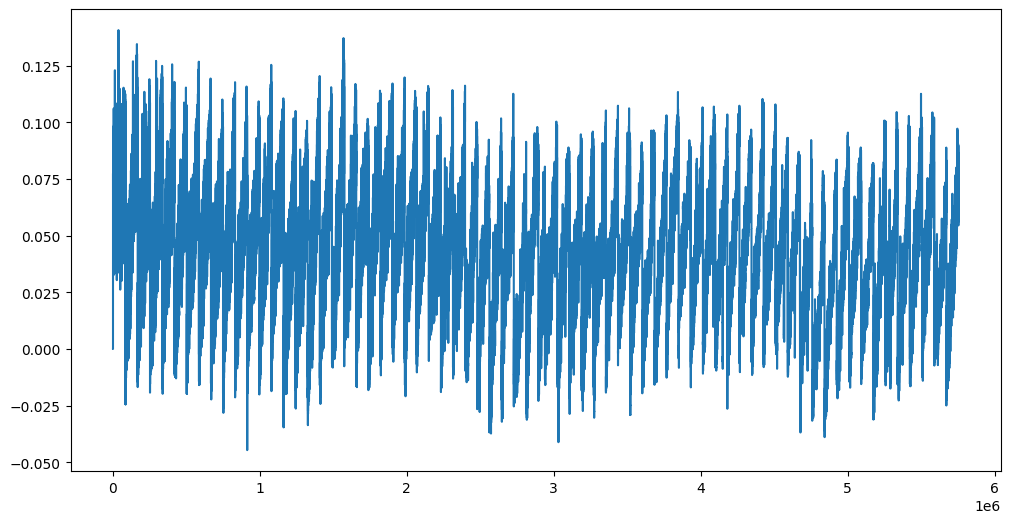

/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_27050/606956807.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



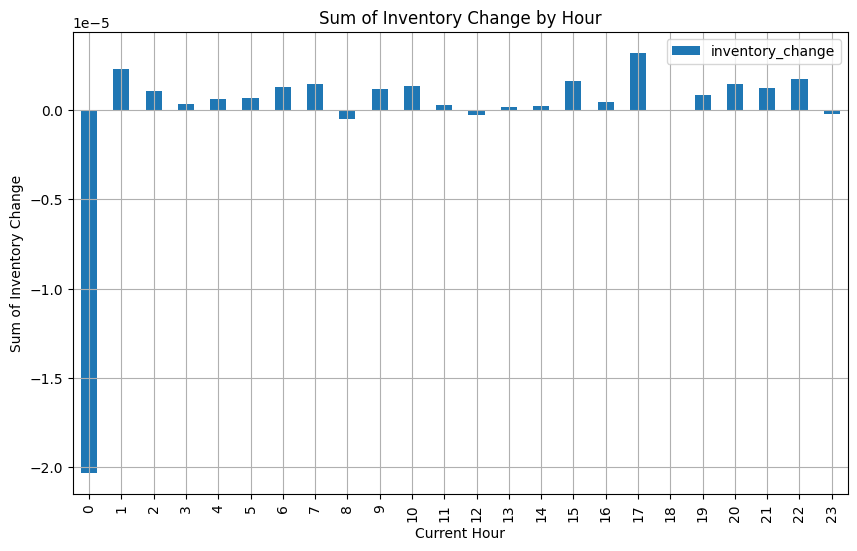

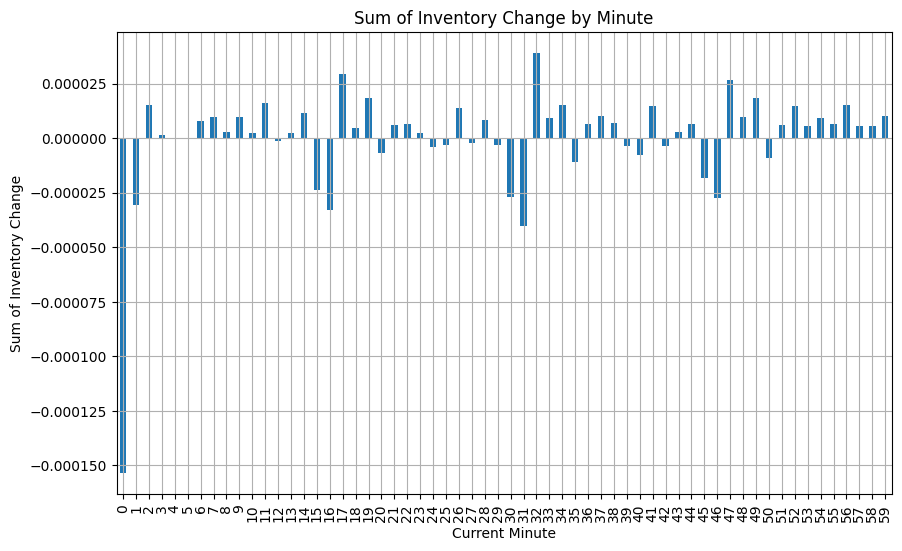

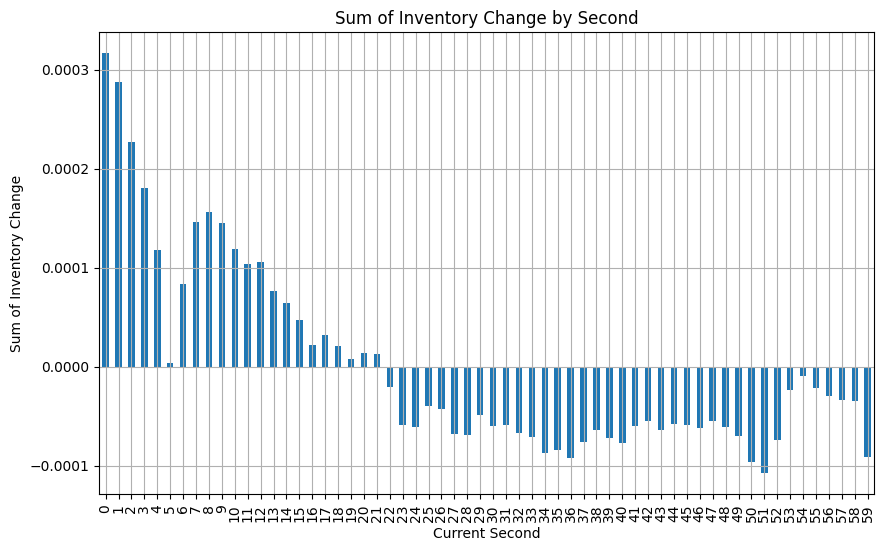

In [345]:
# px.line(df[::25], y='inventory_values')
# px.line(df.iloc[:200000], y='inventory_values')
# px.line(df.inventory_values.diff().rolling(25).mean()[::25])

# jump_std = df.inventory_values.diff().std()
# jump_mean = df.inventory_values.diff().mean()
# jump_threshold = jump_mean + jump_std * 3
# jump_threshold
# df['inventory_jump'] = df.inventory_values.diff()



# jumps = df[df.inventory_values < 0]['inventory_values']

# # Plot 'inventory_values'
# plt.figure(figsize=(12,6))
# plt.plot(df.index, df['inventory_values'], label='Inventory Values')

# # Overlay 'jumps'
# plt.scatter(jumps.index, jumps, color='red', label='Jumps')

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()

# px.line(df[df.inventory_values < 0][['datetime', 'inventory_values']], x='datetime', y='inventory_values')
# df['current_hour'] = df.datetime.dt.hour


# --------------------Inventory net change by hour--------------------
df['current_hour'] = df.datetime.dt.hour
hour_df = df[['current_hour', 'inventory_values']]
hour_df['inventory_change'] = hour_df.inventory_values.diff()
inventory_change_sum = hour_df[['current_hour', 'inventory_change']].groupby('current_hour').mean()

inventory_change_sum.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Current Hour')
plt.ylabel('Average of Inventory Change')
plt.title('Average of Inventory Change by Hour')
plt.grid(True)
plt.show()

# --------------------Inventory net change by minute--------------------
df_copy = df.copy() # Copy the dataframe for safety
df_copy['current_minute'] = df_copy.datetime.dt.minute
df_copy['inventory_change_minute'] = df_copy.inventory_values.diff()
inventory_change_sum_minute = df_copy.groupby('current_minute')['inventory_change_minute'].mean()

inventory_change_sum_minute.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Current Minute')
plt.ylabel('Average of Inventory Change')
plt.title('Average of Inventory Change by Minute')
plt.grid(True)
plt.show()

# --------------------Inventory net change by second--------------------
df_copy['current_second'] = df_copy.datetime.dt.second
df_copy['inventory_change_second'] = df_copy.inventory_values.diff()
inventory_change_sum_second = df_copy.groupby('current_second')['inventory_change_second'].mean()

inventory_change_sum_second.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Current Second')
plt.ylabel('Average of Inventory Change')
plt.title('Average of Inventory Change by Second')
plt.grid(True)
plt.show()


# # --------------------INVENTORY NEGATIVE by hour--------------------
# negative = df[df.inventory_values < 0]
# negative['current_hour'] = negative['current_hour'].astype(int)

# # Get value counts and reindex to fill missing hours with zeros
# value_counts = negative['current_hour'].value_counts().sort_index()
# value_counts = value_counts.reindex(range(24), fill_value=0)

# # Plot as a bar chart
# value_counts.plot(kind='bar', width=0.9)
# plt.xlabel('Current Hour')
# plt.ylabel('Counts')
# plt.title('Negative Inventory Values by Hour')
# plt.grid(True)
# plt.show()



# # --------------------Values net change by hour--------------------
# df_copy = df.copy() # Copy the dataframe for safety
# df_copy['current_hour'] = df_copy.datetime.dt.hour
# df_copy['value_change_hour'] = df_copy['values'].diff()
# value_change_sum_hour = df_copy.groupby('current_hour')['value_change_hour'].mean()

# value_change_sum_hour.plot(kind='bar', figsize=(10, 6))
# plt.xlabel('Current Hour')
# plt.ylabel('Sum of Value Change')
# plt.title('Sum of Value Change by Hour')
# plt.grid(True)
# plt.show()

# # --------------------Values net change by minute--------------------
# df_copy['current_minute'] = df_copy.datetime.dt.minute
# df_copy['value_change_minute'] = df_copy['values'].diff()
# value_change_sum_minute = df_copy.groupby('current_minute')['value_change_minute'].mean()

# value_change_sum_minute.plot(kind='bar', figsize=(10, 6))
# plt.xlabel('Current Minute')
# plt.ylabel('Sum of Value Change')
# plt.title('Sum of Value Change by Minute')
# plt.grid(True)
# plt.show()

# # --------------------Values net change by second--------------------
# df_copy['current_second'] = df_copy.datetime.dt.second
# df_copy['value_change_second'] = df_copy['values'].diff()
# value_change_sum_second = df_copy.groupby('current_second')['value_change_second'].mean()

# value_change_sum_second.plot(kind='bar', figsize=(10, 6))
# plt.xlabel('Current Second')
# plt.ylabel('Sum of Value Change')
# plt.title('Sum of Value Change by Second')
# plt.grid(True)
# plt.show()


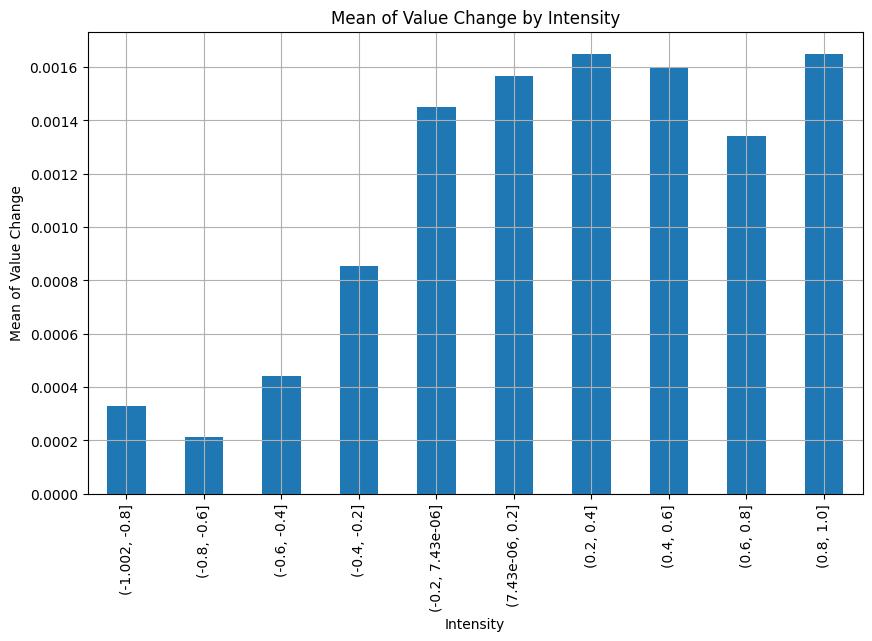

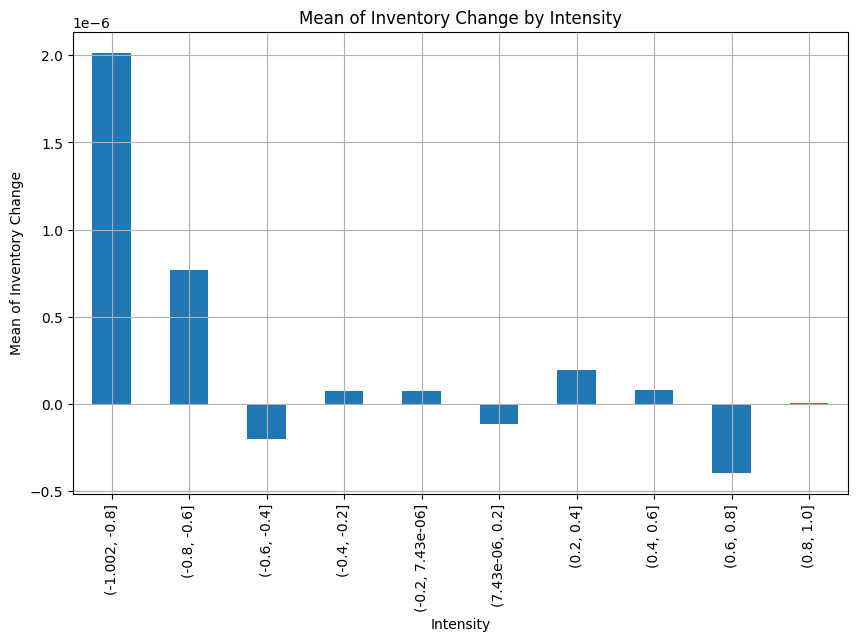

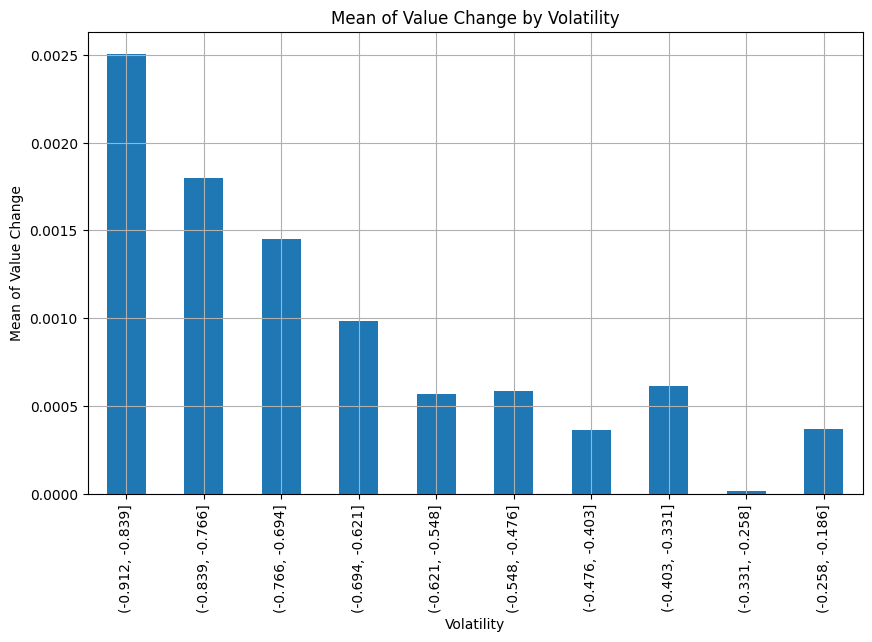

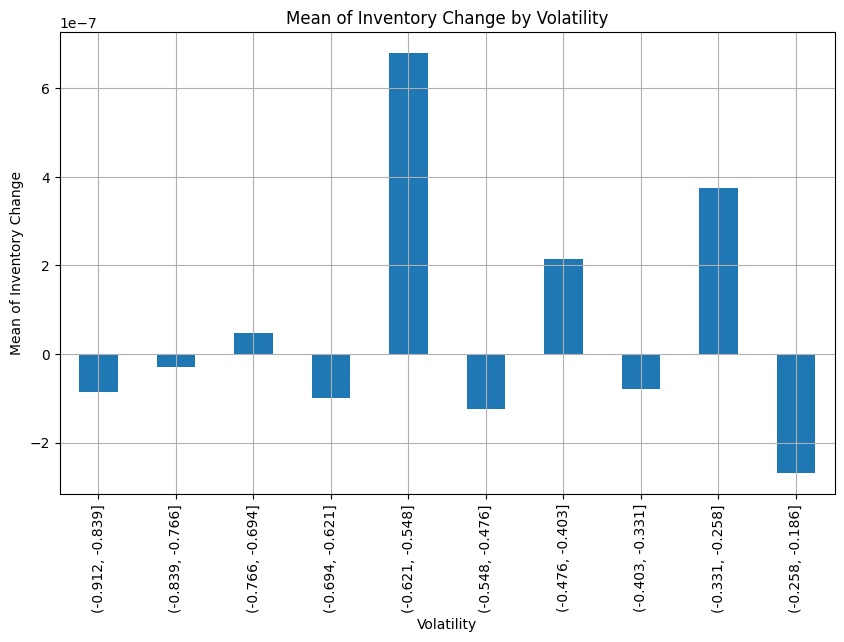

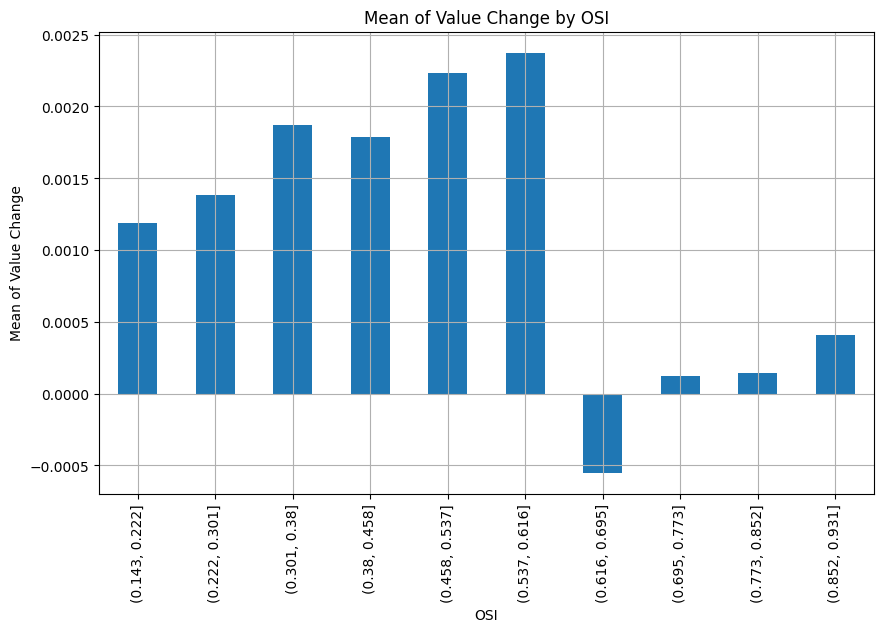

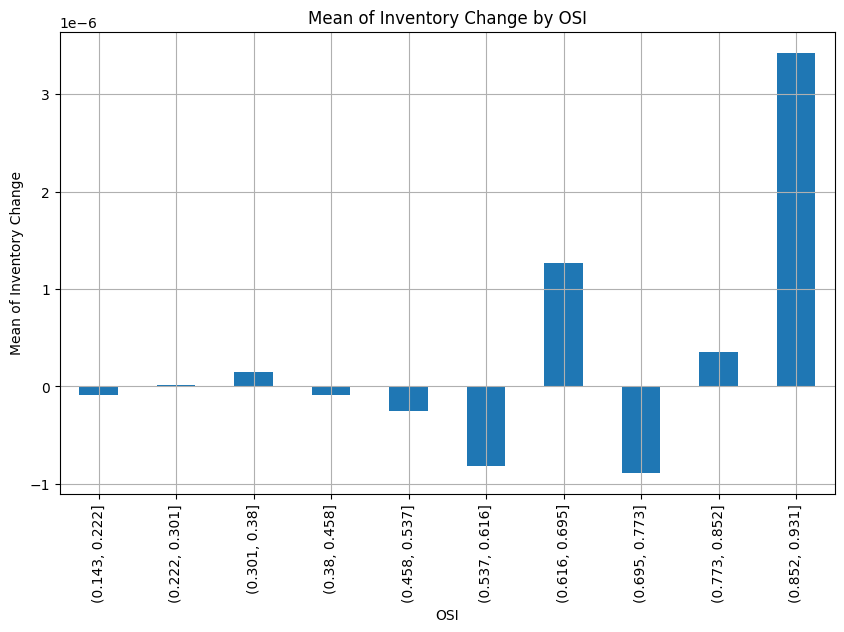

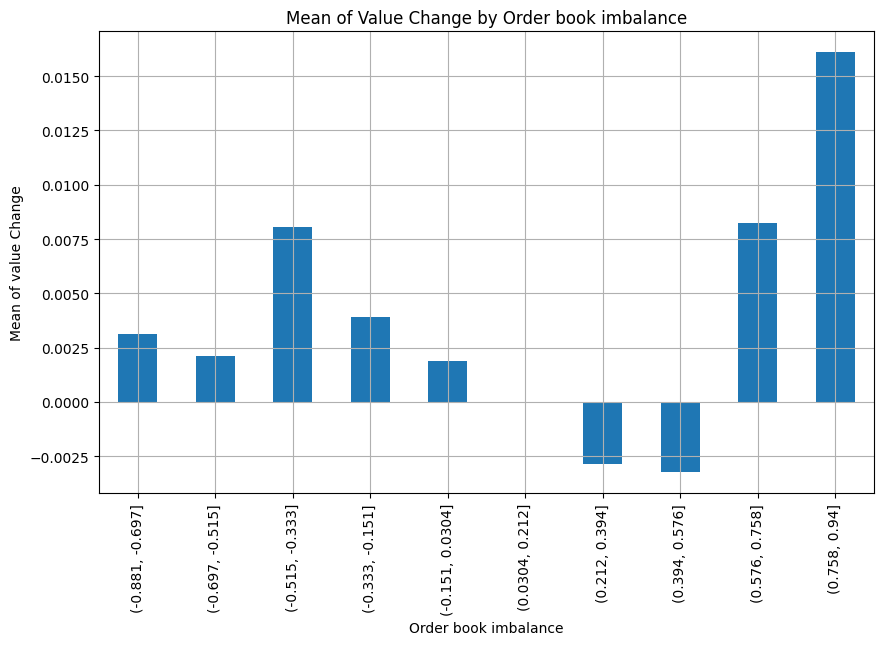

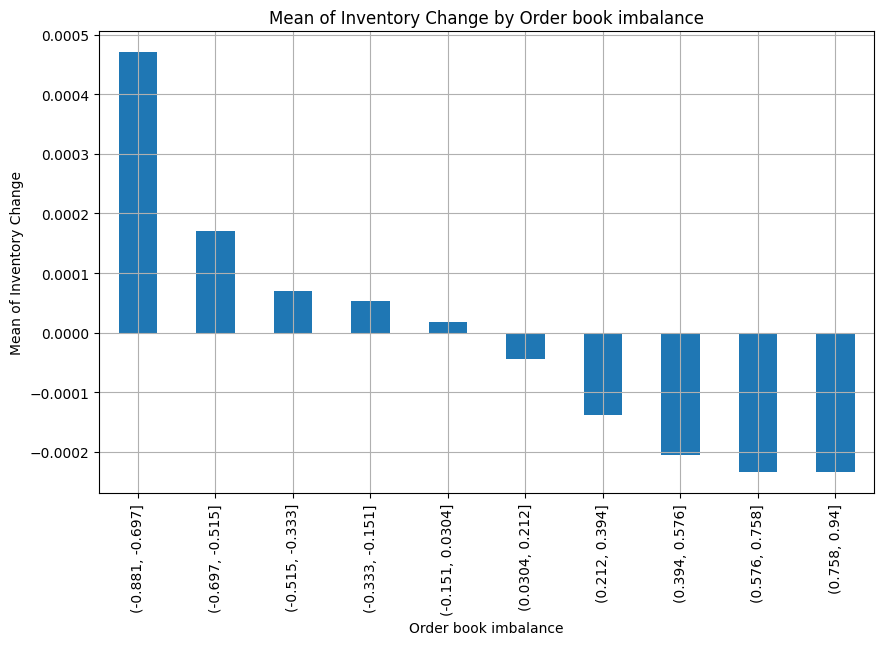

In [363]:
def plot_diff_by_bins(df, column, diff_column, bins, title, y_label, x_label):
    # Create bins for the specified column
    df_copy = df.copy()
    df_copy[f'{column}_bins'] = pd.cut(df_copy[column], bins=bins)

    # Compute the difference in 'values'
    df_copy['value_change'] = df_copy[diff_column].diff()

    # Group by the bins and compute the sum
    binned_value_change_sum = df_copy.groupby(f'{column}_bins')['value_change'].mean()

    # Plot the result
    binned_value_change_sum.plot(kind='bar', figsize=(10, 6))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()


plot_diff_by_bins(df, "intensity", "values",10, "Mean of Value Change by Intensity", "Mean of Value Change", "Intensity")
plot_diff_by_bins(df, "intensity", "inventory",10, "Mean of Inventory Change by Intensity", "Mean of Inventory Change", "Intensity")

plot_diff_by_bins(df, "volatility", "values",10, "Mean of Value Change by Volatility", "Mean of Value Change", "Volatility")
plot_diff_by_bins(df, "volatility", "inventory",10, "Mean of Inventory Change by Volatility", "Mean of Inventory Change", "Volatility")

plot_diff_by_bins(df, "osi", "values",10, "Mean of Value Change by OSI", "Mean of Value Change", "OSI")
plot_diff_by_bins(df, "osi", "inventory",10, "Mean of Inventory Change by OSI", "Mean of Inventory Change", "OSI")


plot_diff_by_bins(df, "order_book_imbalance", "values",10, "Mean of Value Change by Order book imbalance", "Mean of value Change", "Order book imbalance")
plot_diff_by_bins(df, "order_book_imbalance", "inventory",10, "Mean of Inventory Change by Order book imbalance", "Mean of Inventory Change", "Order book imbalance")


In [339]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_full_as_comparison.csv")
df

,mid_price,values,inventory_values,inventory_qty,bid_size_model,ask_size_model,bid_model,ask_model,bid_size_expert,ask_size_expert,bid_expert,ask_expert,norm_inv,volatility,intensity,osi,order_book_imbalance,current_second,current_minute,current_hour
0,1.11985,NaN,NaN,NaN,1.0,0.0,-1.0,-1.0,0.2,0.2,-3303.113483,3303.113483,0.000000,-0.636710,-0.999983,0.9306,0.1235,-1.000000,-1.0,-1.000000
1,1.11970,NaN,NaN,NaN,1.0,0.0,-1.0,-1.0,0.2,0.2,-3303.113483,3303.113483,0.000000,-0.636710,-0.999983,0.9306,0.1144,-0.933333,-1.0,-1.000000
2,1.12005,NaN,NaN,NaN,1.0,0.0,-1.0,-1.0,0.2,0.2,-3303.113483,3303.113483,0.000000,-0.636710,-0.999983,0.9306,-0.0135,-0.900000,-1.0,-1.000000
3,1.12065,NaN,NaN,NaN,1.0,0.0,-1.0,-1.0,0.2,0.2,-3303.113483,3303.113483,0.000000,-0.636710,-0.999983,0.9306,-0.0098,-0.866667,-1.0,-1.000000
4,1.12045,NaN,NaN,NaN,1.0,0.0,-1.0,-1.0,0.2,0.2,-3303.113483,3303.113483,0.000000,-0.636710,-0.999983,0.9306,-0.0145,-0.833333,-1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048710,NaN,1222.1202,0.11728,138.0,1.0,1.0,-1.0,-1.0,0.2,0.2,-0.194177,0.144358,0.058640,-0.787607,0.268399,0.4068,-0.0046,-0.500000,0.2,0.333333
2048711,NaN,1222.1206,0.11564,136.0,1.0,1.0,-1.0,-1.0,0.2,0.2,-0.194177,0.144358,0.058640,-0.787607,0.268399,0.4068,-0.0827,-0.466667,0.2,0.333333
2048712,NaN,1222.2024,0.11732,138.0,1.0,1.0,-1.0,-1.0,0.2,0.2,-0.193829,0.144706,0.057820,-0.787607,0.268399,0.4068,-0.1049,-0.433333,0.2,0.333333
2048713,NaN,1222.1750,0.11901,140.0,1.0,1.0,-1.0,-1.0,0.2,0.2,-0.194185,0.144350,0.058660,-0.787607,0.268399,0.4068,-0.0884,-0.400000,0.2,0.333333


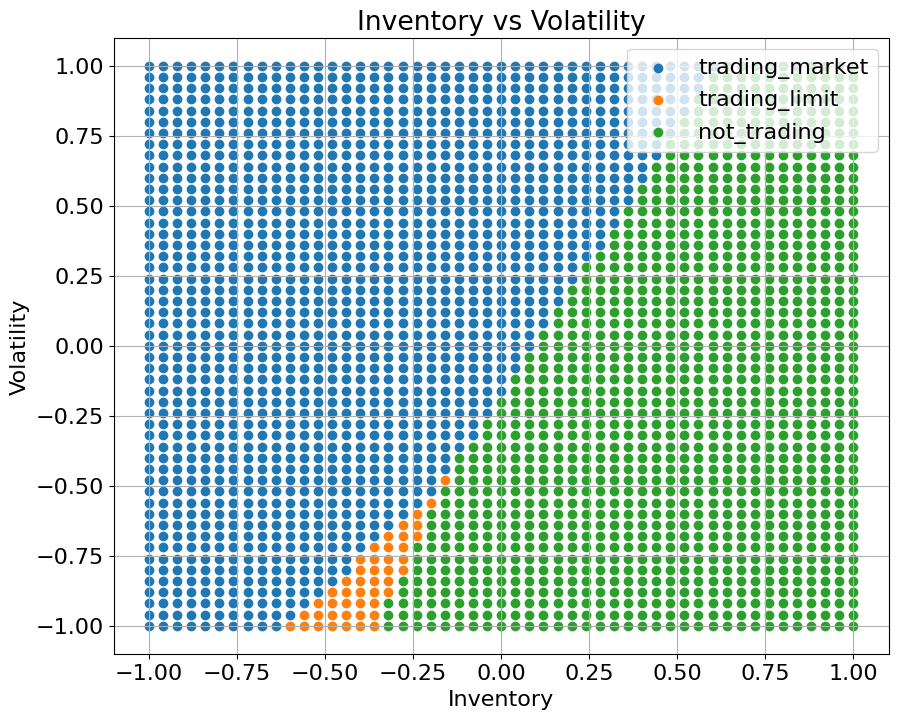

KeyError: 'choices'

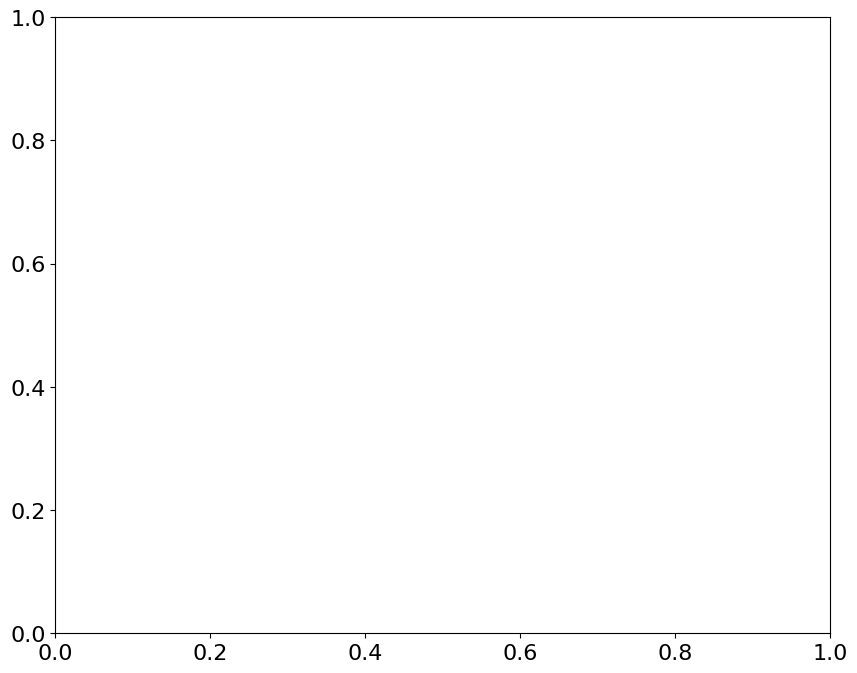

In [10]:
config = get_config("decision_grid", subdirectory=["research_configs"])
create_model_decision_grid(config)

df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")

columns = ['inventory', 'volatility', 'ml_policy_bid_size', 'ml_policy_ask_size', 'ml_policy_bid', 'ml_policy_ask']
df = df[columns]
df['is_bid'] = df.ml_policy_bid_size != 0
df['is_ask'] = df.ml_policy_ask_size != 0
df['bid_cross_spread'] = df.ml_policy_bid > 0
df['ask_cross_spread'] = df.ml_policy_ask < 0

choices = ['not_trading', 'trading_limit', 'trading_market']


def get_choice(row):
    if row['is_bid'] or row['is_ask']:
        if row['bid_cross_spread'] or row['ask_cross_spread']:
            return 'trading_market'
        else:
            return 'trading_limit'
    else:
        return 'not_trading'

# Apply the function to the dataframe
df['ask_choices'] = df.apply(get_choice, axis=1)

plt.figure(figsize=(10,8))

for choice in df['ask_choices'].unique():
    plt.scatter(df[df['ask_choices']==choice]['inventory'], df[df['ask_choices']==choice]['volatility'], label=choice)

plt.title('Inventory vs Volatility')
plt.xlabel('Inventory')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# df['volatility_str'] = 'volatility_' + df['volatility'].astype(str)
# # df["intensity_str"] = "intensity_" + df["intensity"].astype(str)
# g = sns.FacetGrid(df, hue="volatility_str", height=5, aspect=2)
# g = g.map(plt.plot, "inventory", "ml_policy_ask")
# g.add_legend()

# plt.show()
# px.line(df, x="volatility", y=['ml_policy_bid', 'as_policy_bid'])
# px.line(df, x="volatility", y=['ml_policy_ask', 'as_policy_ask','ml_policy_bid', 'as_policy_bid'])
# px.line(df, x="inventory", y=['ml_policy_ask','ml_policy_bid'])



# Create a label (category) encoder object
le = LabelEncoder()

# Define the grid
x_grid = np.linspace(df['inventory'].min(), df['inventory'].max(), 500)
y_grid = np.linspace(df['volatility'].min(), df['volatility'].max(), 500)
X, Y = np.meshgrid(x_grid, y_grid)
df['ask_choices'] = le.fit_transform(df['ask_choices'])

# Plot for bids
fig, ax = plt.subplots(figsize=(10,8))

df_bids = df[df['is_bid']]

Z_bids = griddata((df_bids['inventory'], df_bids['volatility']), df_bids['choices'], (X, Y), method='nearest')

cmap = plt.get_cmap('viridis', df_bids['choices'].nunique())
c = ax.contourf(X, Y, Z_bids, levels=np.arange(df_bids['choices'].nunique()+1)-0.5, cmap=cmap)
cbar = fig.colorbar(c)
cbar.set_ticks(np.arange(df_bids['choices'].nunique()))
cbar.set_ticklabels(le.inverse_transform(df_bids['choices'].unique()))
plt.title('Bid decisions')
plt.xlabel('Inventory')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [138]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
y_column = "volatility"
x_column = "inventory"
columns = [x_column, y_column, 'ml_policy_bid_size', 'ml_policy_ask_size', 'ml_policy_bid', 'ml_policy_ask']
df = df[columns]

df['buy_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
df['buy_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
df['no_buy'] = df.ml_policy_bid_size == 0

df['sell_market'] = (df.ml_policy_ask_size != 0) & (df.ml_policy_ask < 0)
df['sell_limit'] = (df.ml_policy_ask_size != 0) & (df.ml_policy_ask > 0)
df['no_sell'] = df.ml_policy_ask_size == 0



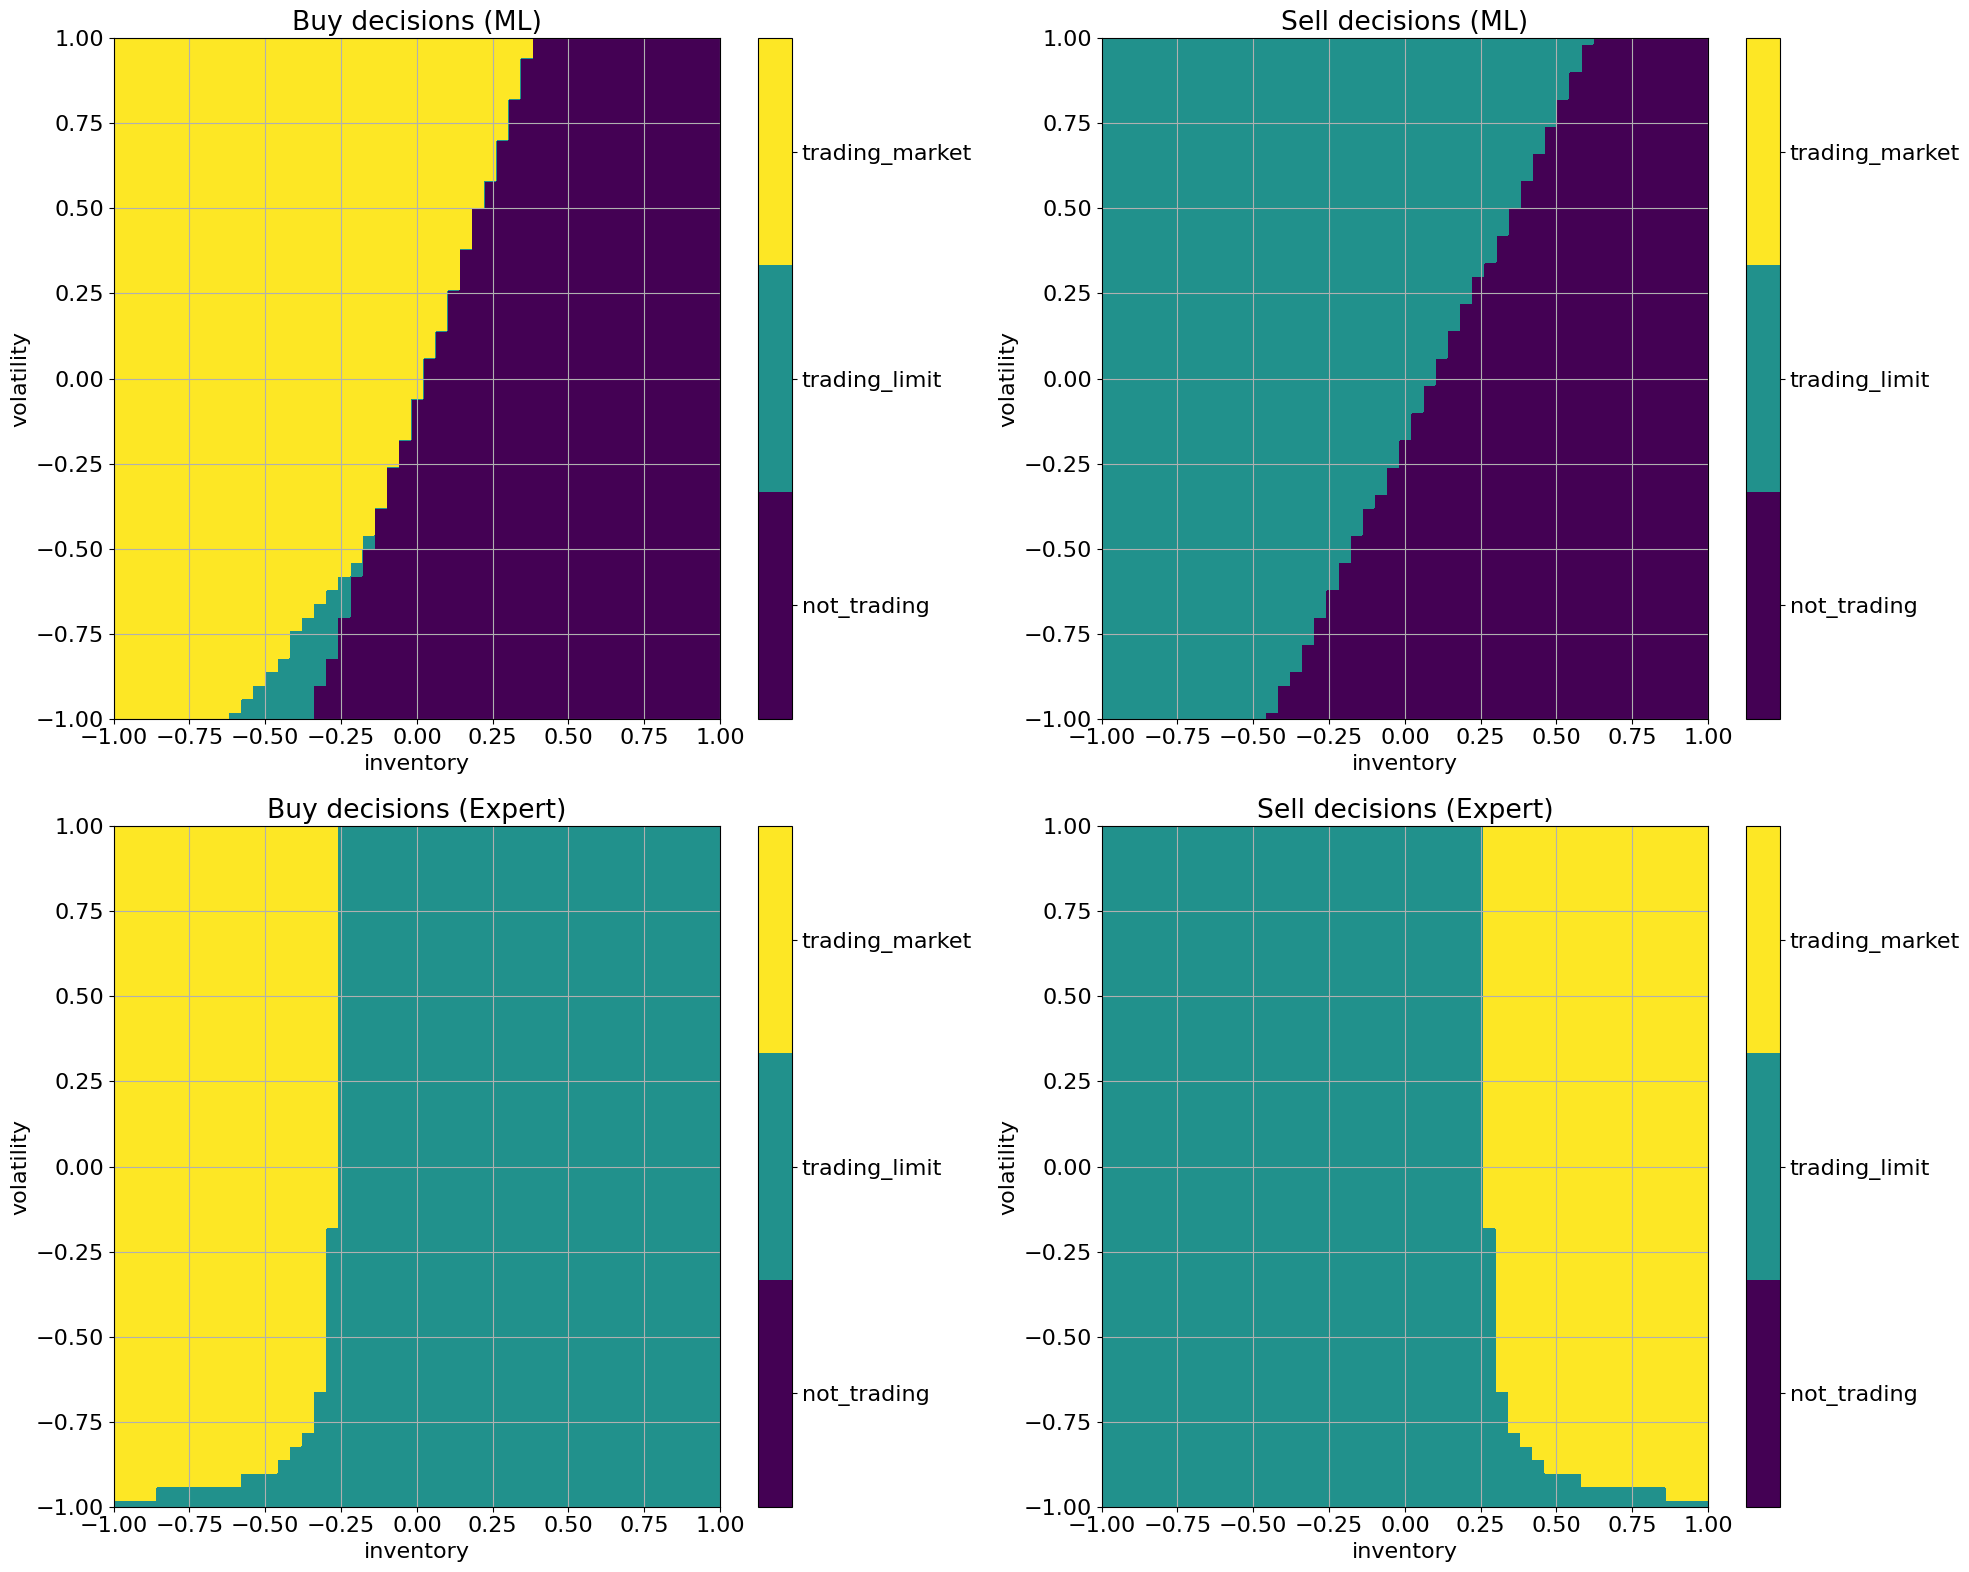

In [139]:
x_grid = np.linspace(df['inventory'].min(), df['inventory'].max(), 500)
y_grid = np.linspace(df['volatility'].min(), df['volatility'].max(), 500)
X, Y = np.meshgrid(x_grid, y_grid)

def create_decision_grid(df, bid_size_col, ask_size_col, bid_col, ask_col, title_suffix):
    df_buy = df.copy()
    df_buy['trading_market'] = (df[bid_size_col] != 0) & (df[bid_col] > 0)
    df_buy['trading_limit'] = (df[bid_size_col] != 0) & (df[bid_col] < 0)
    df_buy['not_trading'] = df[bid_size_col] == 0

    df_sell = df.copy()
    df_sell['trading_market'] = (df[ask_size_col] != 0) & (df[ask_col] < 0)
    df_sell['trading_limit'] = (df[ask_size_col] != 0) & (df[ask_col] > 0)
    df_sell['not_trading'] = df[ask_size_col] == 0

    return df_buy, df_sell

def plot_decision_grid(ax, df, x_column, y_column, title):
    Z = griddata((df[x_column], df[y_column]), df[choices].values.argmax(axis=1), (X, Y), method='nearest')

    cmap = plt.get_cmap('viridis', len(choices))
    c = ax.contourf(X, Y, Z, levels=np.arange(len(choices) + 1) - 0.5, cmap=cmap)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_ticks(np.arange(len(choices)))
    cbar.set_ticklabels(choices)
    ax.set_title(title)
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.grid(True)

config = get_config("decision_grid", subdirectory=["research_configs"])
create_model_decision_grid(config)
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")

# define your x, y columns and choices
y_column = "volatility"
x_column = "inventory"
choices = ['not_trading', 'trading_limit', 'trading_market']

# columns for ML and Expert
columns_ml = [x_column, y_column, 'ml_policy_bid_size', 'ml_policy_ask_size', 'ml_policy_bid', 'ml_policy_ask']
columns_expert = [x_column, y_column, 'as_policy_bid_size', 'as_policy_ask_size', 'as_policy_bid', 'as_policy_ask']

# create decision grids
df_ml_buy, df_ml_sell = create_decision_grid(df[columns_ml], 'ml_policy_bid_size', 'ml_policy_ask_size', 'ml_policy_bid', 'ml_policy_ask', 'ML')
df_expert_buy, df_expert_sell = create_decision_grid(df[columns_expert], 'as_policy_bid_size', 'as_policy_ask_size', 'as_policy_bid', 'as_policy_ask', 'Expert')

plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# plot decision grids
plot_decision_grid(axs[0, 0], df_ml_buy, x_column, y_column, 'Buy decisions (ML)')
plot_decision_grid(axs[0, 1], df_ml_sell, x_column, y_column, 'Sell decisions (ML)')
plot_decision_grid(axs[1, 0], df_expert_buy, x_column, y_column, 'Buy decisions (Expert)')
plot_decision_grid(axs[1, 1], df_expert_sell, x_column, y_column, 'Sell decisions (Expert)')

plt.tight_layout()
plt.show()




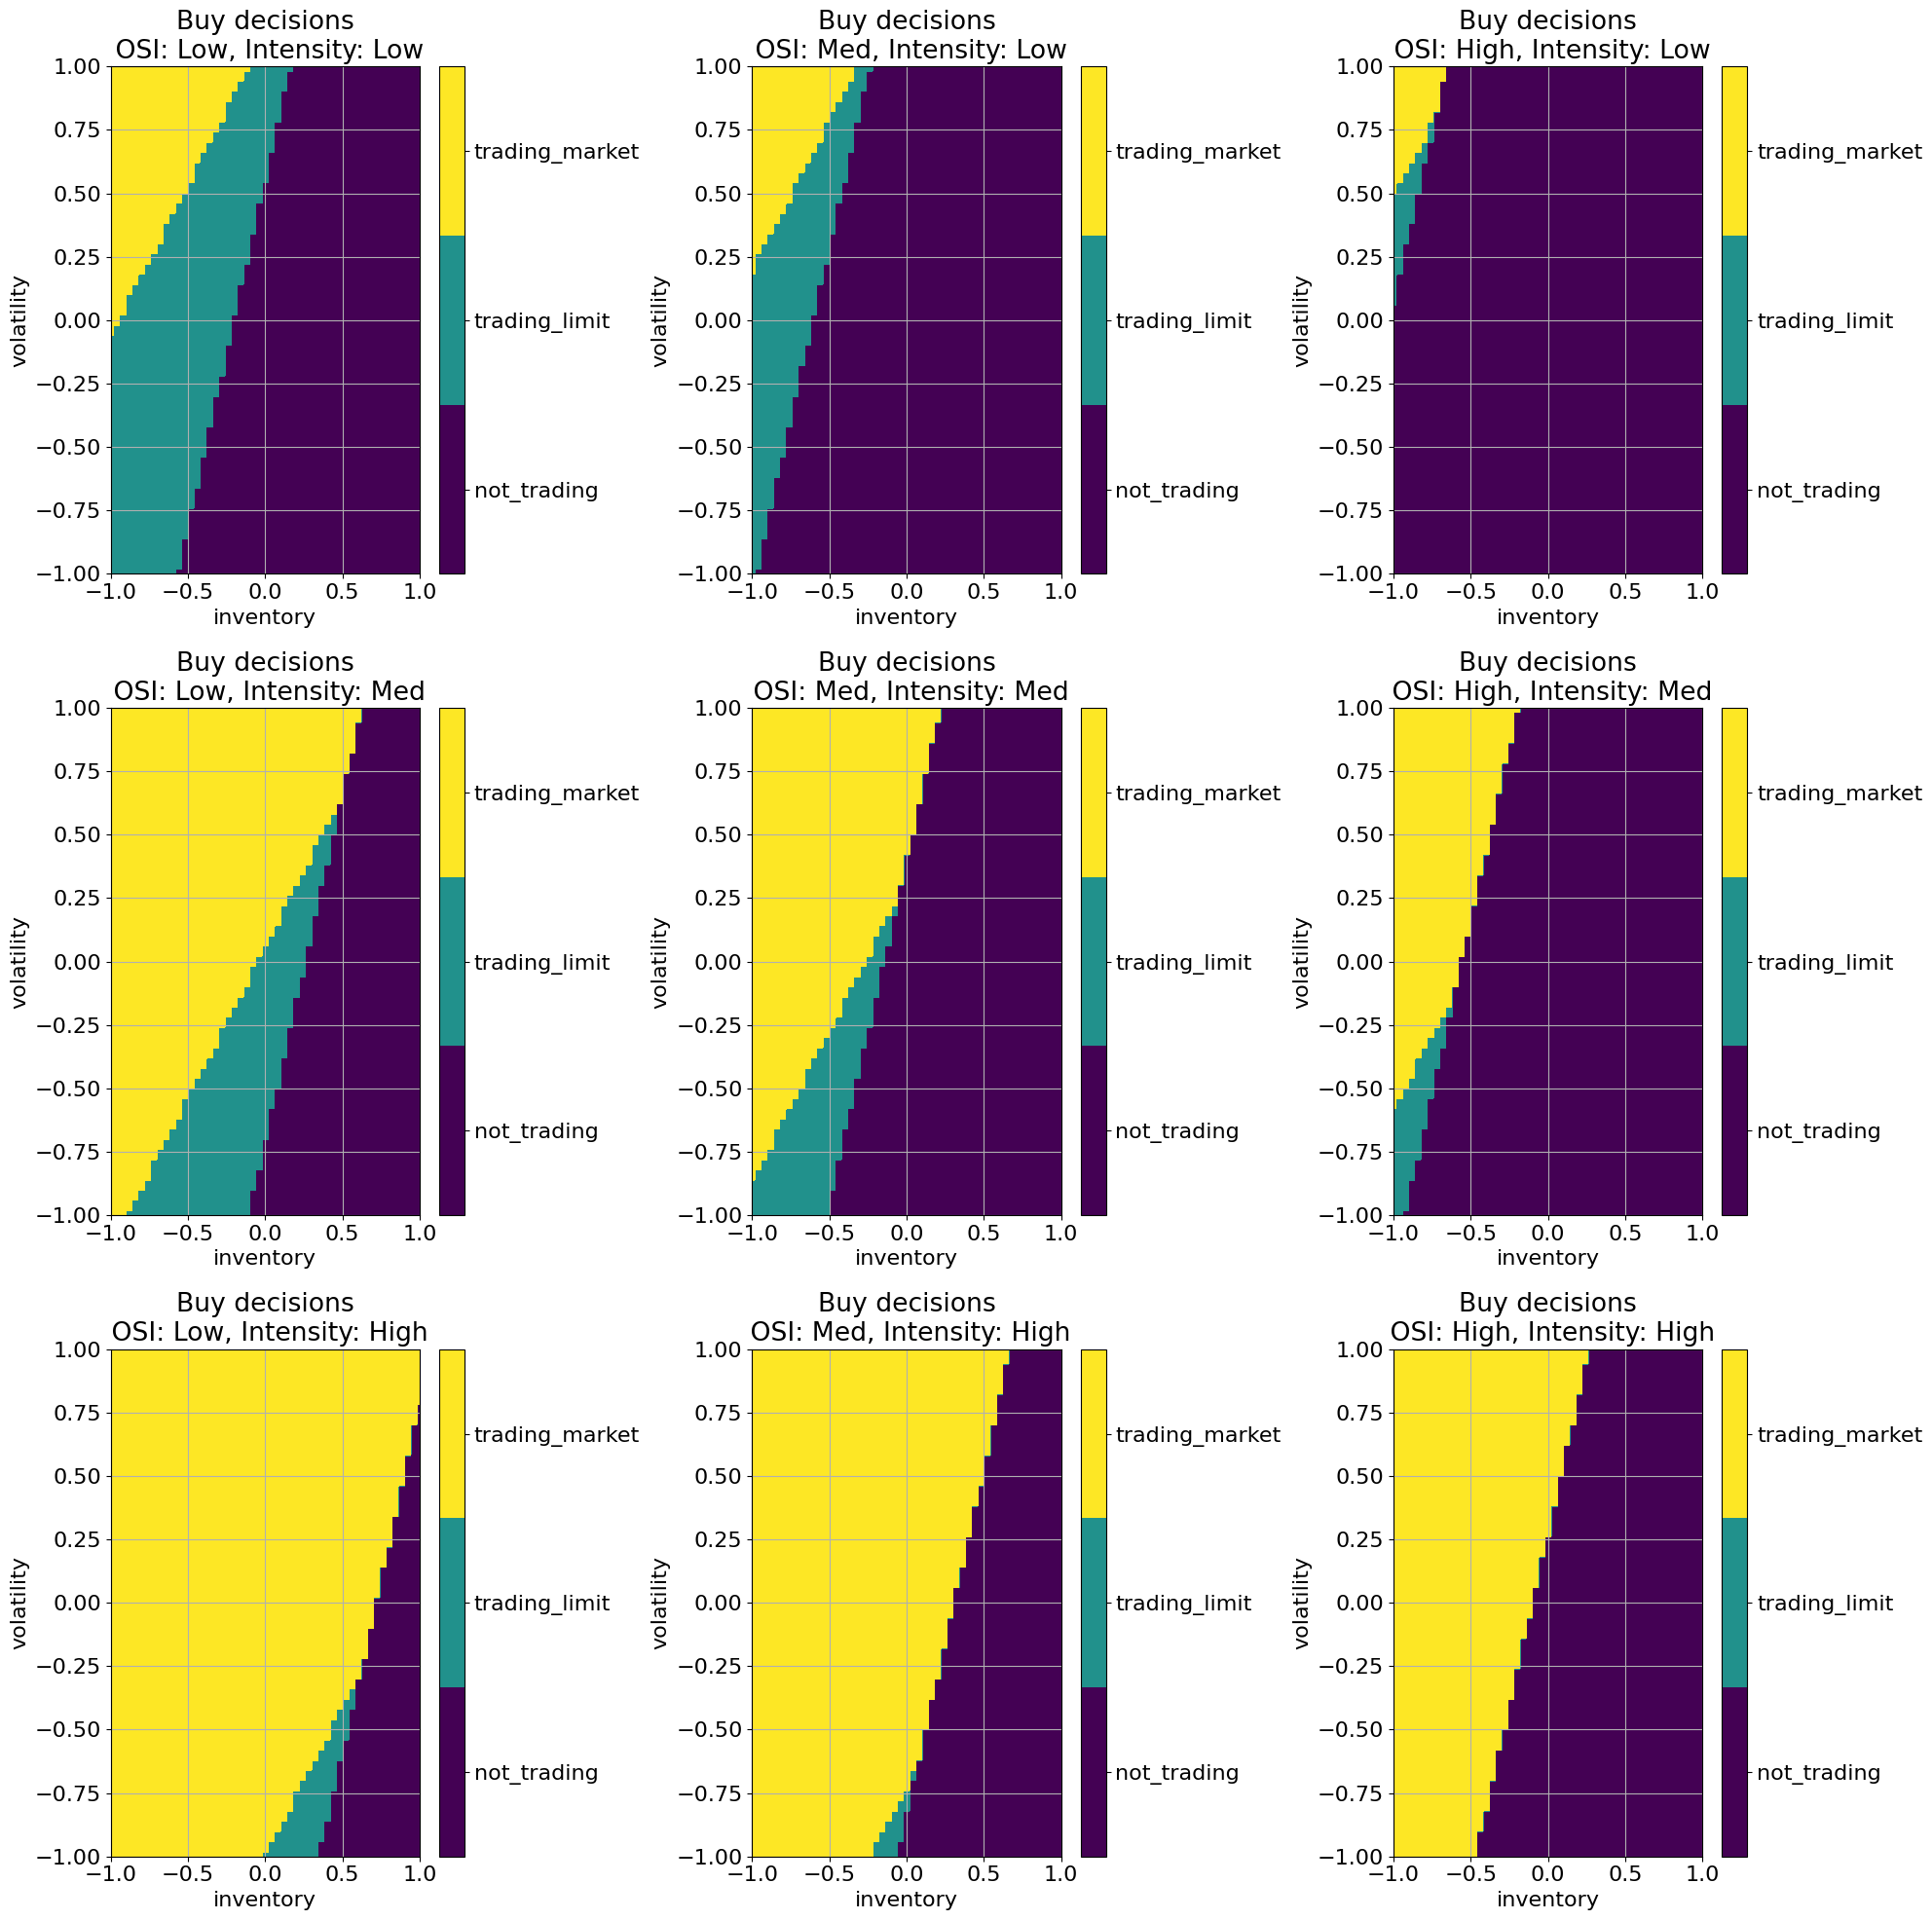

In [140]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, intensity in enumerate(list(value_mapping.keys())):
    for j, osi in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.intensity = intensity
        config.decision_grid.constant_values.osi = osi
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'Buy decisions\n OSI: {value_mapping[osi]}, Intensity: {value_mapping[intensity]}')

plt.tight_layout()
plt.show()


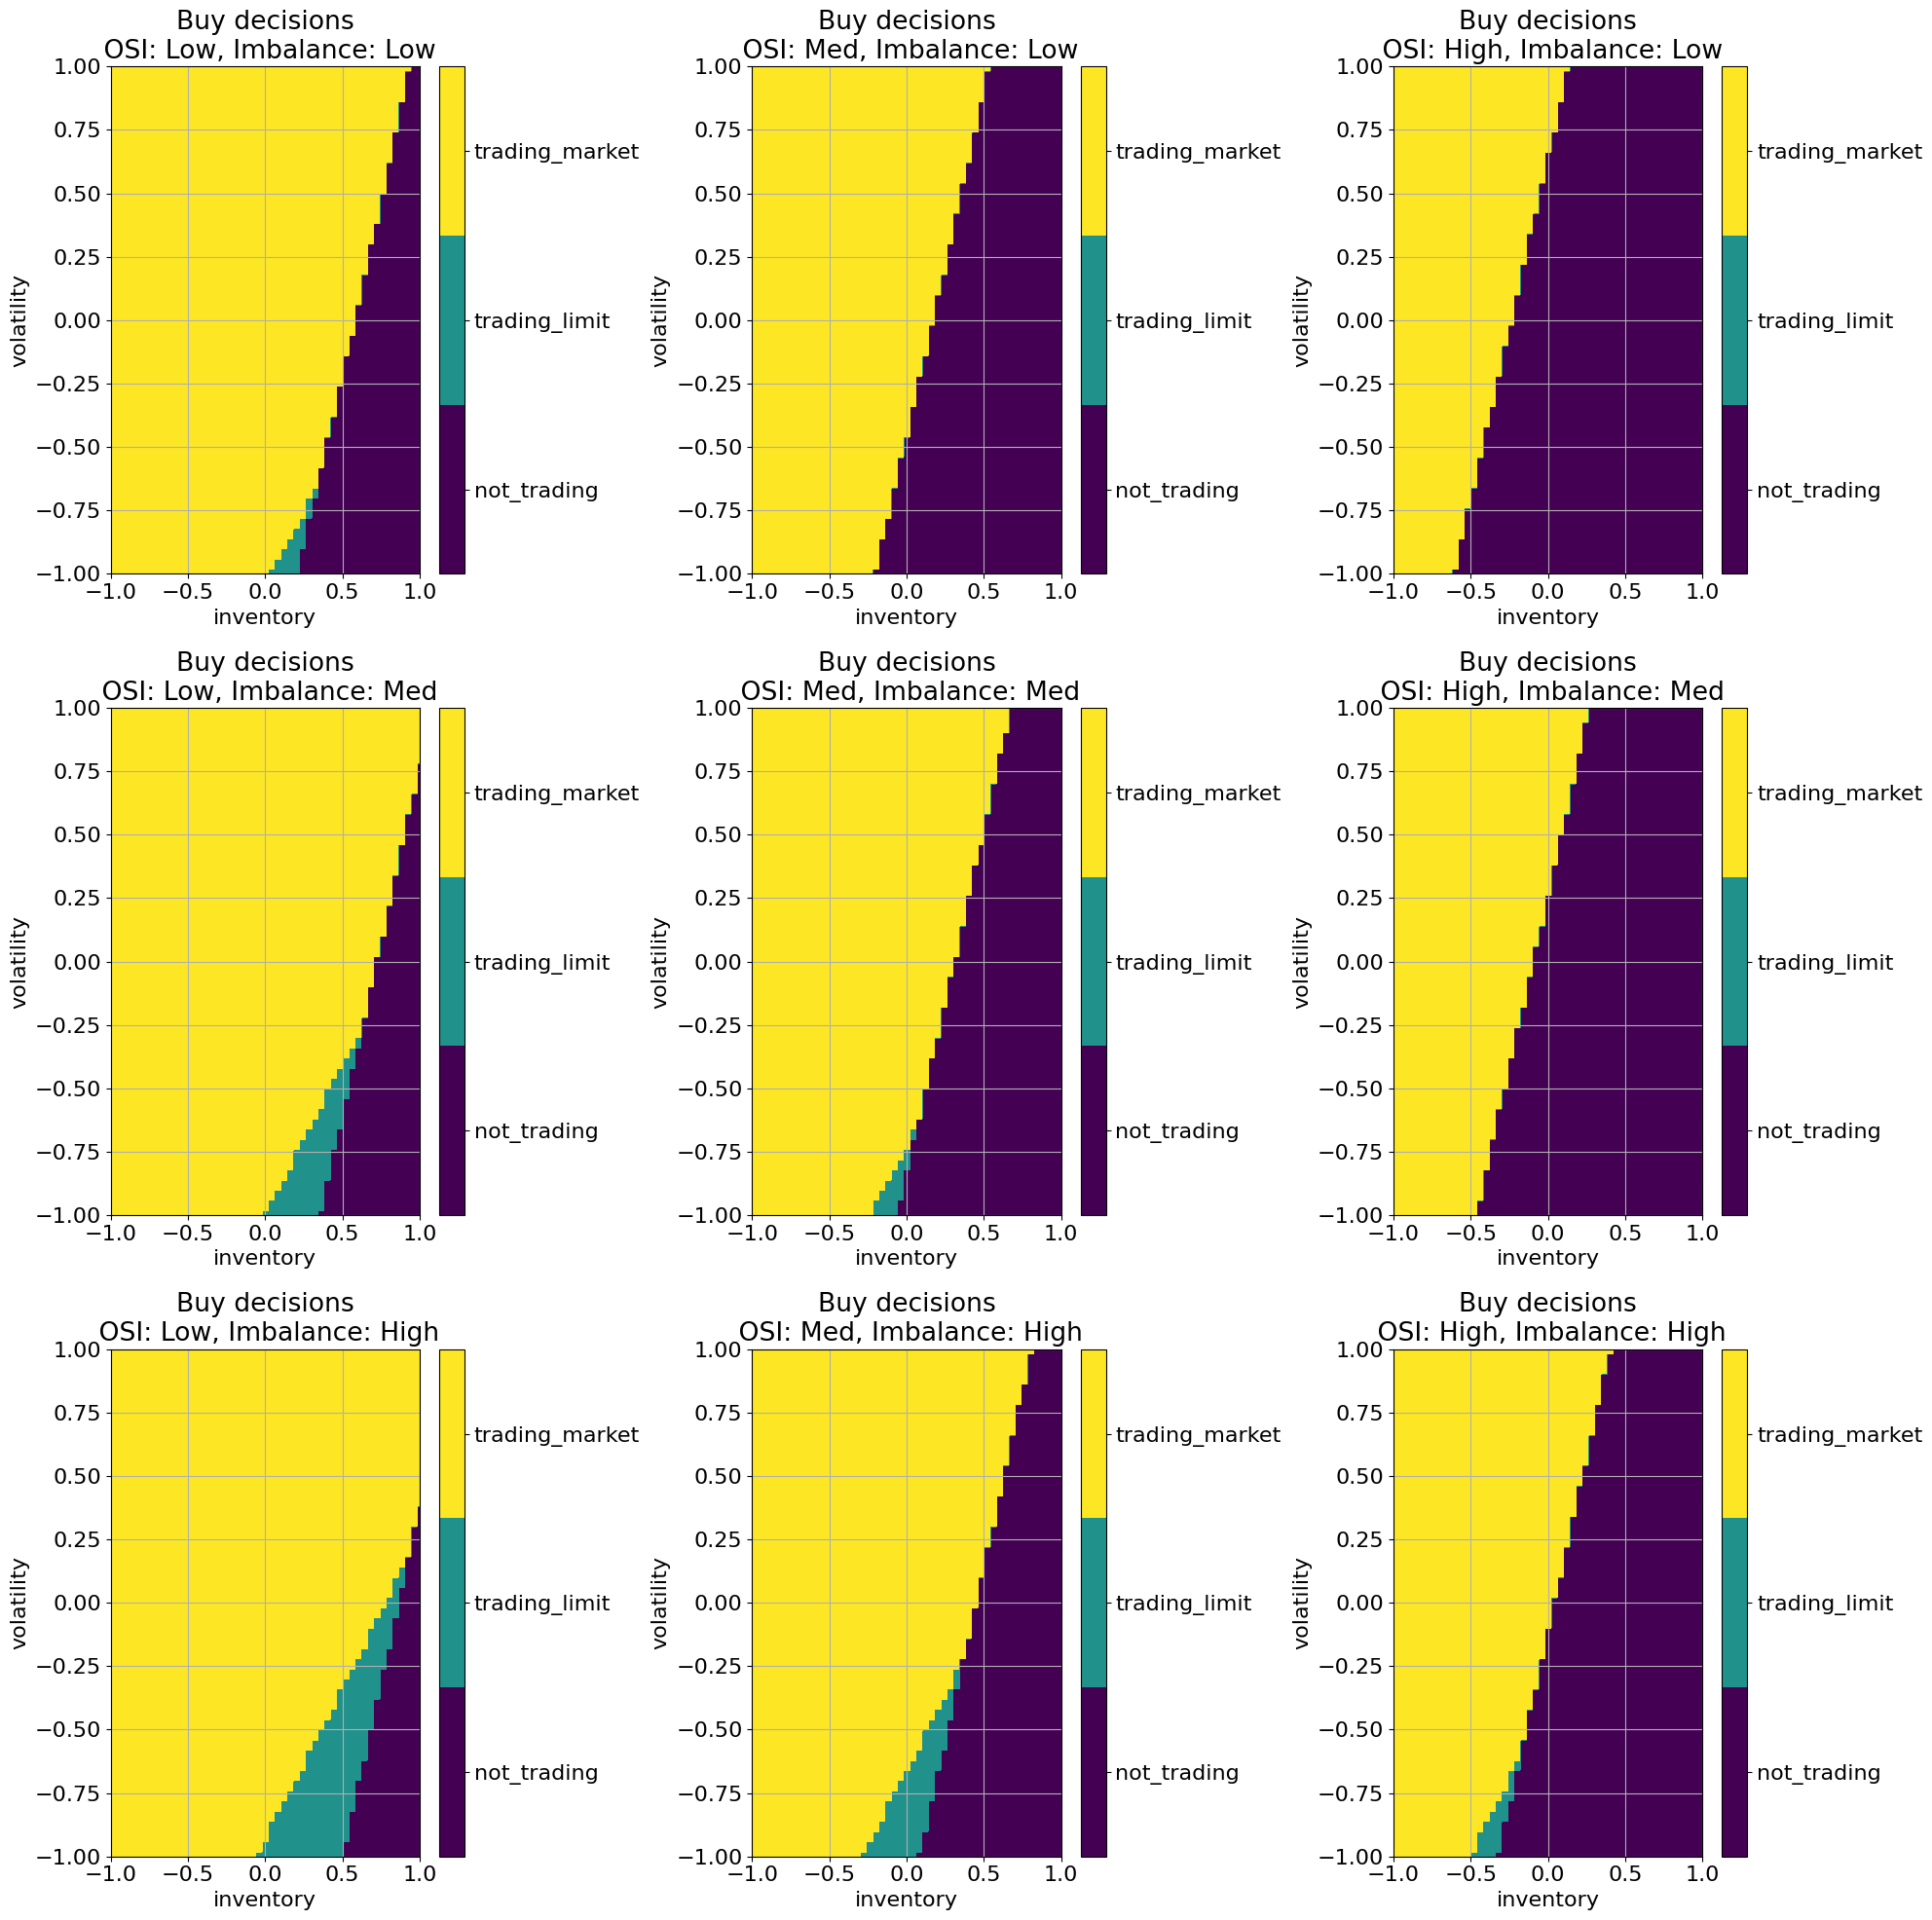

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, order_book_imbalance in enumerate(list(value_mapping.keys())):
    for j, osi in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.order_book_imbalance = order_book_imbalance
        config.decision_grid.constant_values.osi = osi
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'Buy decisions\n OSI: {value_mapping[osi]}, Imbalance: {value_mapping[order_book_imbalance]}')

plt.tight_layout()
plt.show()


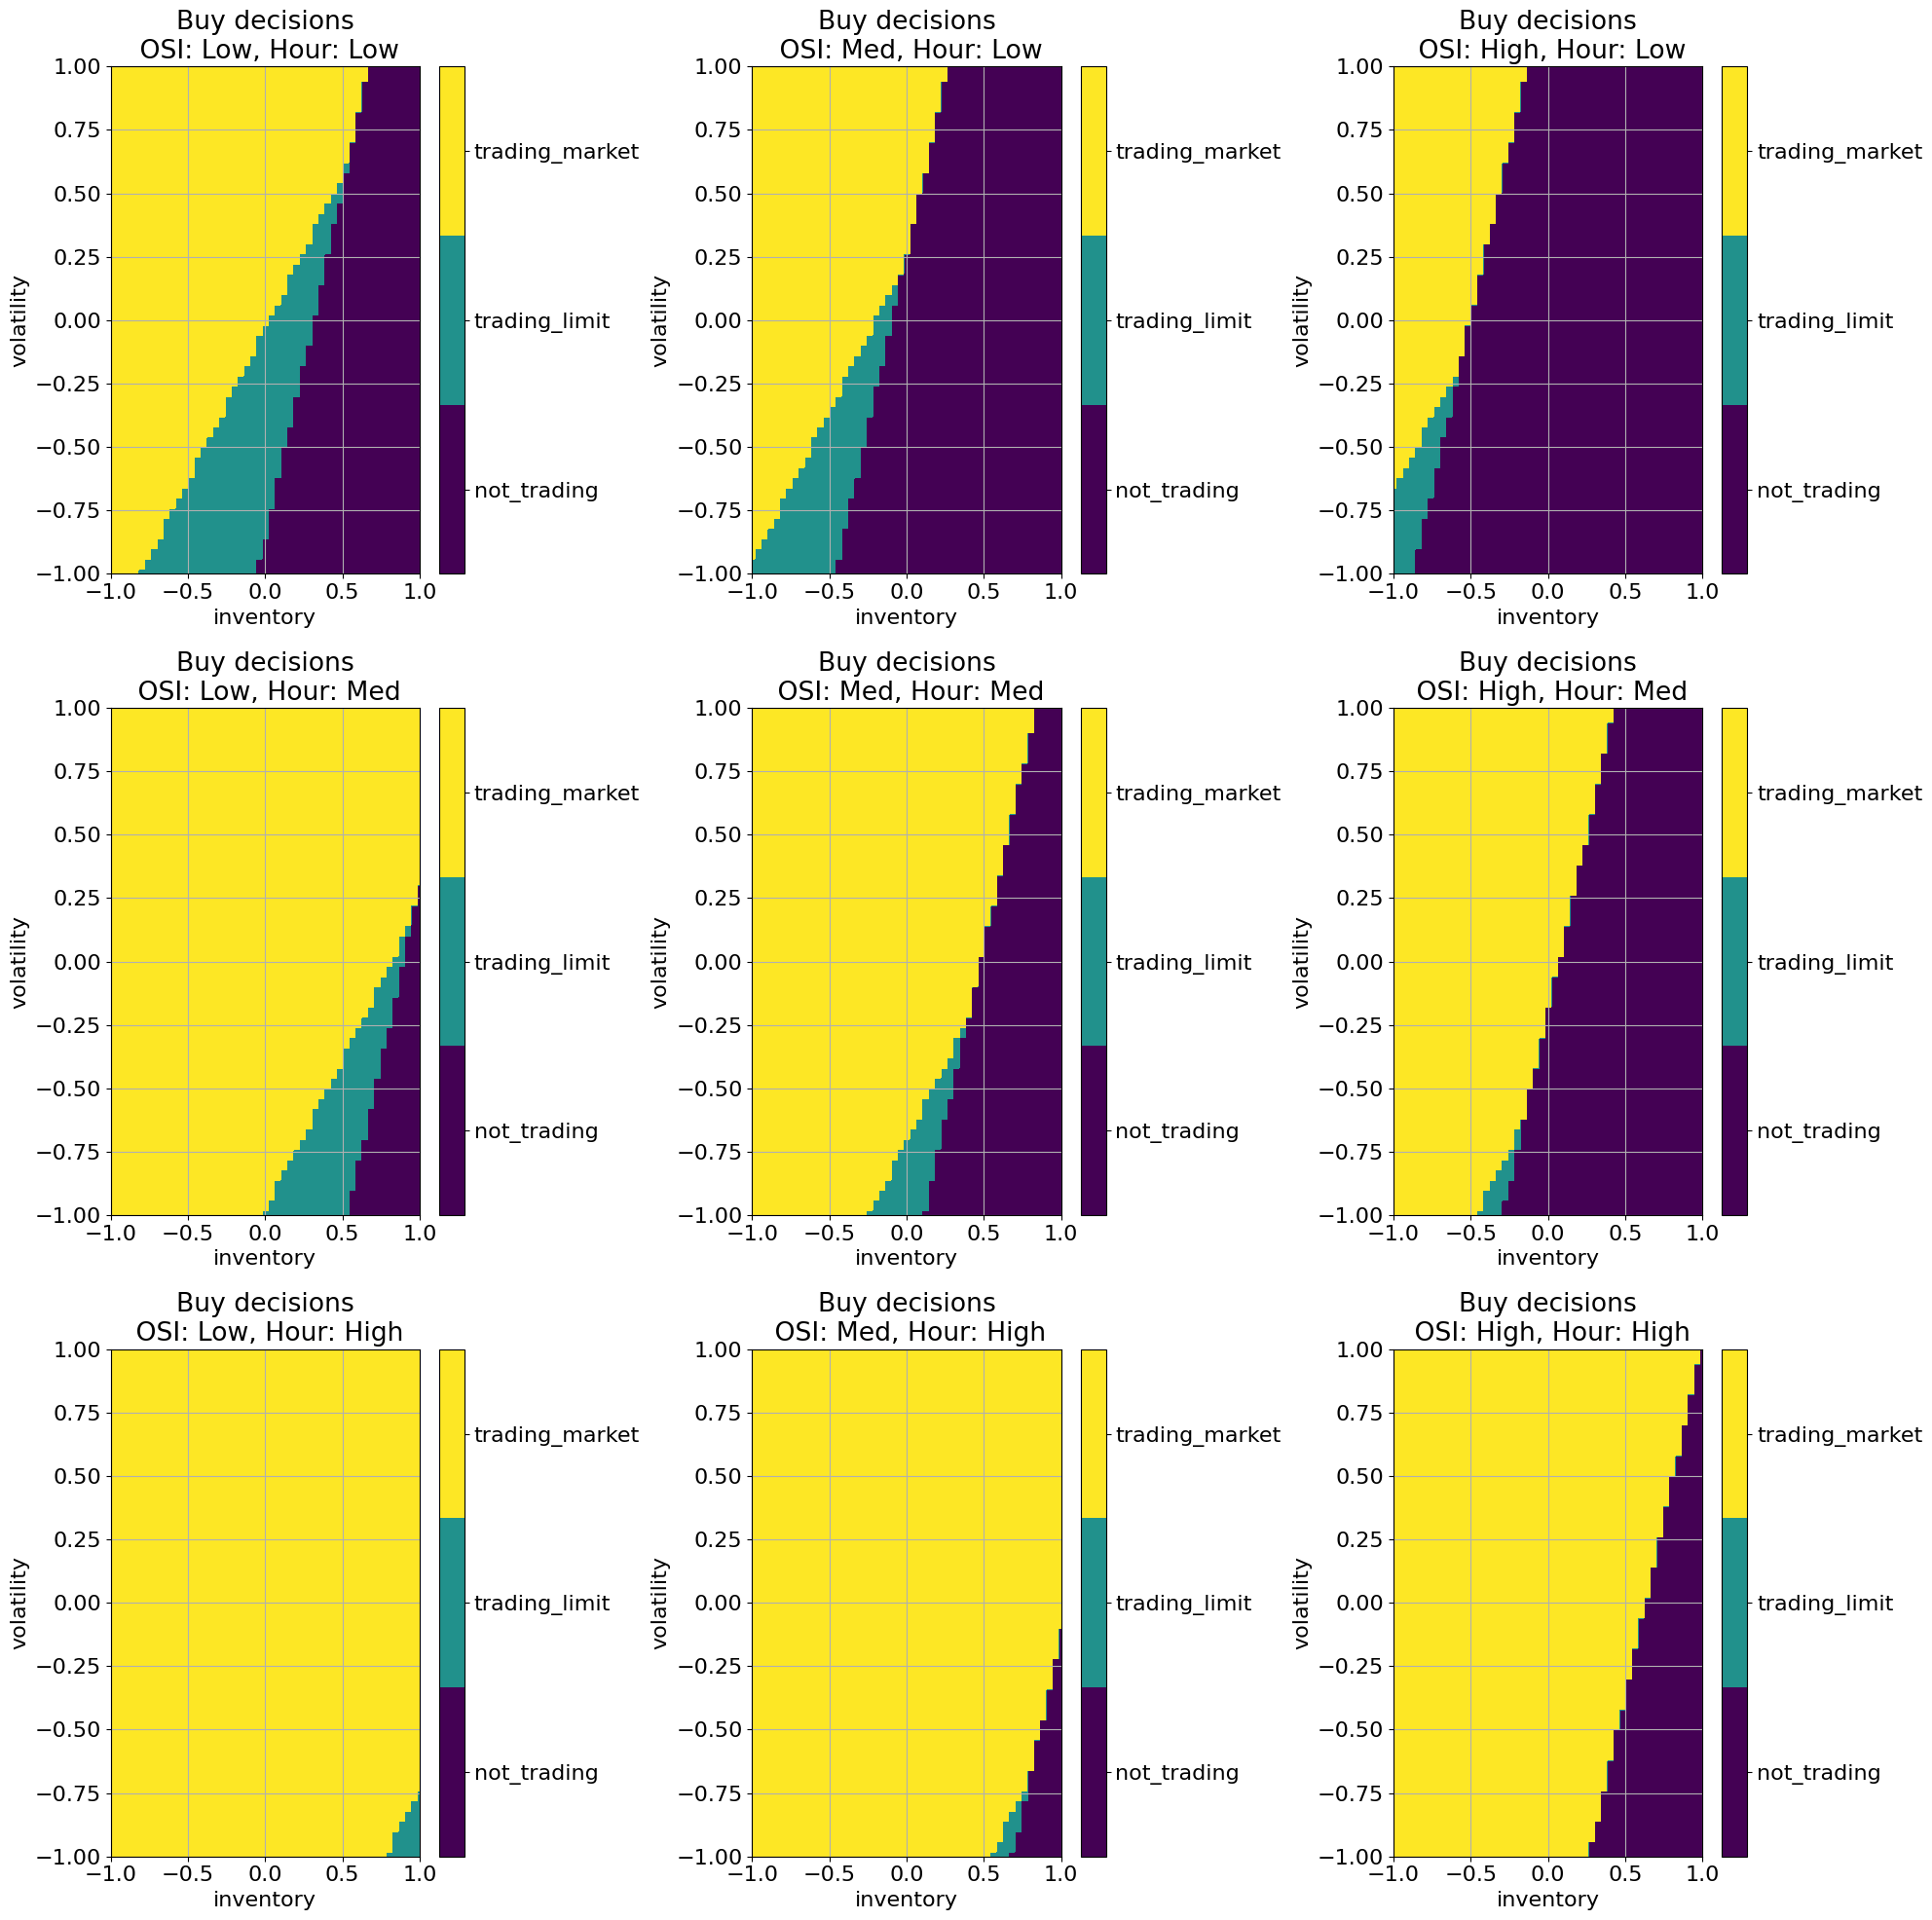

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, current_hour in enumerate(list(value_mapping.keys())):
    for j, osi in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.current_hour = current_hour
        config.decision_grid.constant_values.osi = osi
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'Buy decisions\n OSI: {value_mapping[osi]}, Hour: {value_mapping[current_hour]}')

plt.tight_layout()
plt.show()


NameError: name 'visual_folder' is not defined

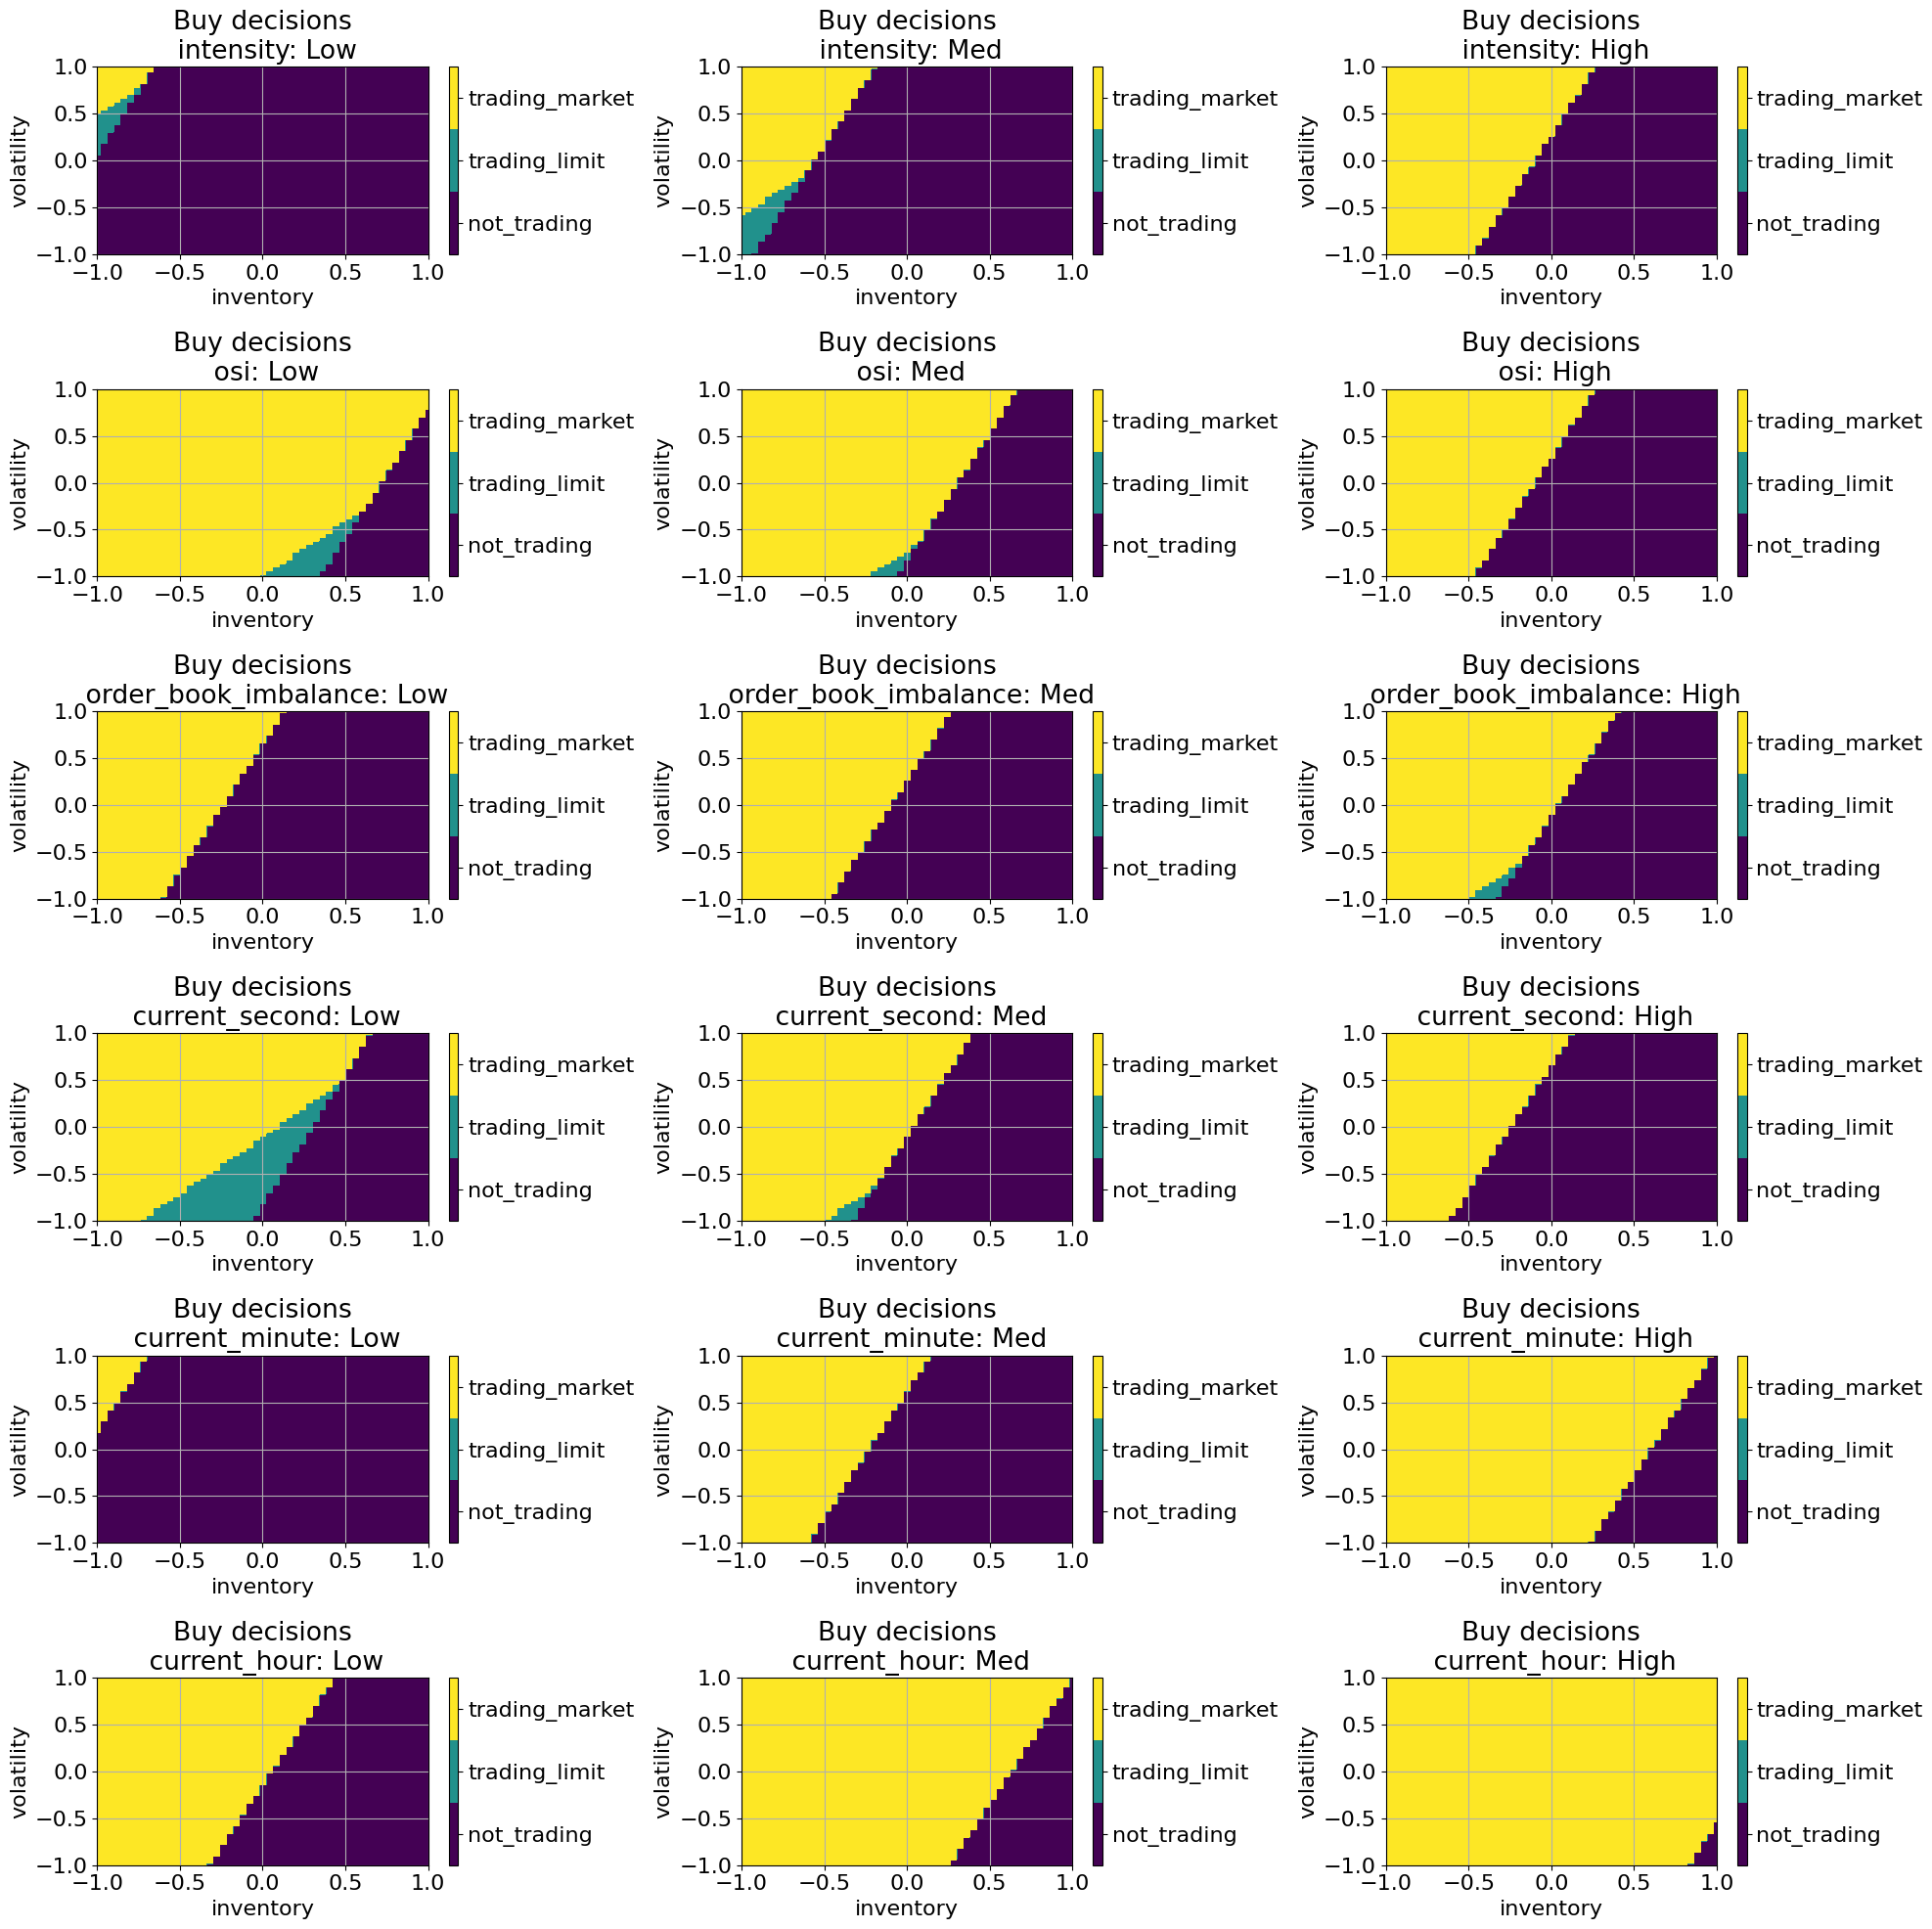

In [141]:
fig, axs = plt.subplots(len(config.decision_grid.constant_values.keys()), 3, figsize=(20, 20))

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over keys of config.decision_grid.constant_values
for i, key in enumerate(config.decision_grid.constant_values.keys()):
    for j, value in enumerate(list(value_mapping.keys())):
        # Update config with current value for the key
        config.decision_grid.constant_values[key] = value
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'Buy decisions\n {key}: {value_mapping[value]}')

plt.tight_layout()
# plt.savefig(os.path.join(visual_folder, 'decision_grid_matrix.png'))
plt.show()


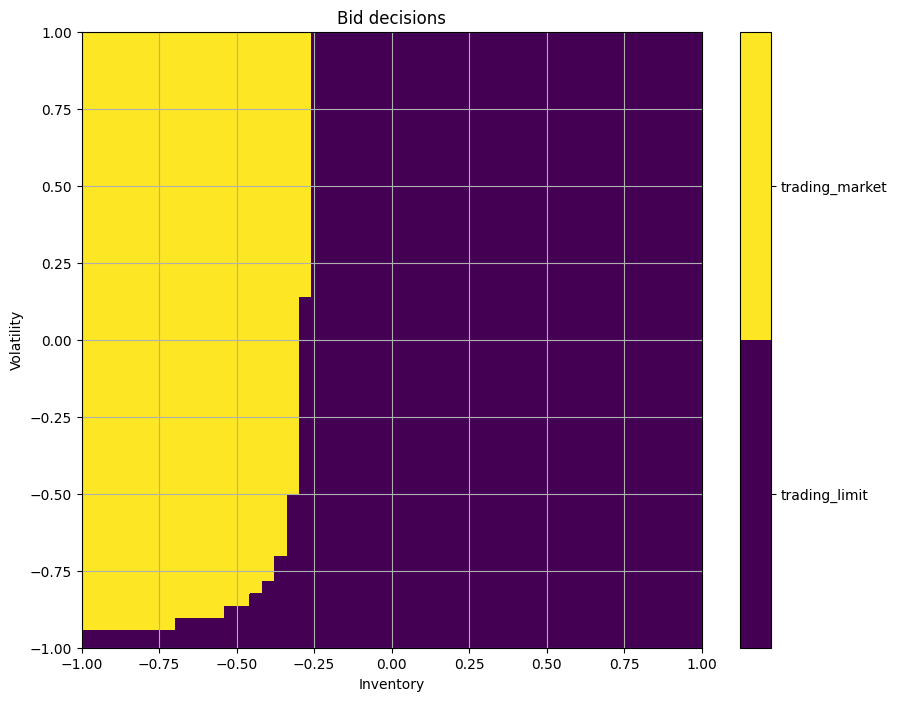

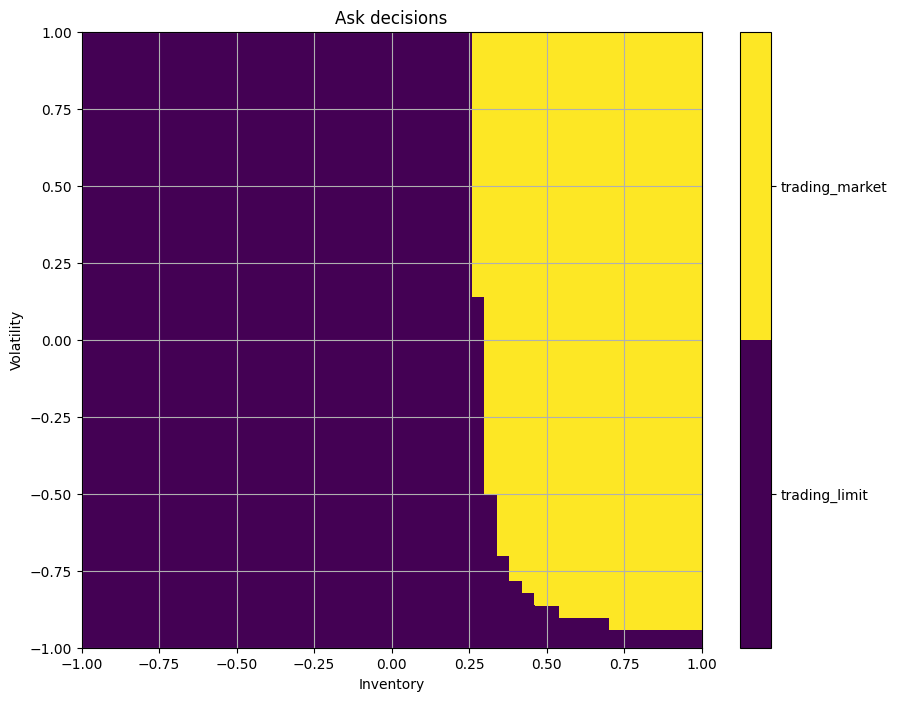

In [37]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
df
columns = ['inventory', 'volatility', 'as_policy_bid_size', 'as_policy_ask_size', 'as_policy_bid', 'as_policy_ask']
df = df[columns]
df['is_bid'] = df.as_policy_bid_size != 0
df['is_ask'] = df.as_policy_ask_size != 0
df['bid_cross_spread'] = df.as_policy_bid > 0
df['ask_cross_spread'] = df.as_policy_ask < 0

bid_choices = []
ask_choices = []
for idx, row in df.iterrows():
    if row['is_bid']:
        if row['bid_cross_spread']:
            bid_choices.append('trading_market')
        else:
            bid_choices.append('trading_limit')
    else:
        bid_choices.append('not_trading')

    if row['is_ask']:
        if row['ask_cross_spread']:
            ask_choices.append('trading_market')
        else:
            ask_choices.append('trading_limit')
    else:
        ask_choices.append('not_trading')
df['bid_choices'] = bid_choices
df['ask_choices'] = ask_choices
# Encode the categorical data
le_bid = LabelEncoder()
df['bid_choices'] = le_bid.fit_transform(df['bid_choices'])

le_ask = LabelEncoder()
df['ask_choices'] = le_ask.fit_transform(df['ask_choices'])

granularity = 500


# Define the grid
x_grid = np.linspace(df['inventory'].min(), df['inventory'].max(), granularity)
y_grid = np.linspace(df['volatility'].min(), df['volatility'].max(), granularity)
X, Y = np.meshgrid(x_grid, y_grid)

# Plot for bids
fig, ax = plt.subplots(figsize=(10,8))


Z_bids = griddata((df['inventory'], df['volatility']), df['bid_choices'], (X, Y), method='nearest')

cmap = plt.get_cmap('viridis', df['bid_choices'].nunique())
c = ax.contourf(X, Y, Z_bids, levels=np.arange(df['bid_choices'].nunique()+1)-0.5, cmap=cmap)
cbar = fig.colorbar(c)
cbar.set_ticks(np.arange(df['bid_choices'].nunique()))
cbar.set_ticklabels(le_bid.inverse_transform(df['bid_choices'].unique()))
plt.title('Bid decisions')
plt.xlabel('Inventory')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

# Plot for asks
fig, ax = plt.subplots(figsize=(10,8))


Z_asks = griddata((df['inventory'], df['volatility']), df['ask_choices'], (X, Y), method='nearest')

cmap = plt.get_cmap('viridis', df['ask_choices'].nunique())
c = ax.contourf(X, Y, Z_asks, levels=np.arange(df['ask_choices'].nunique()+1)-0.5, cmap=cmap)
cbar = fig.colorbar(c)
cbar.set_ticks(np.arange(df['ask_choices'].nunique()))
cbar.set_ticklabels(le_ask.inverse_transform(df['ask_choices'].unique()))
plt.title('Ask decisions')
plt.xlabel('Inventory')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [74]:
def aggregation_function_rewards(df):
    grouping = {
    "sharpe_min":('sharpe', 'min'),
    "sharpe_max":('sharpe', 'max'),
    "sharpe_std":('sharpe', 'std'),
    "sharpe_var":('sharpe', 'var'),
    "sharpe_mean":('sharpe', 'mean'),
    "max_inventory_all": ('max_inventory', 'max'),
    }

    df_grouped = df.groupby('trial_group').agg(
        **{col:(col,'mean') for col in df.columns if col != 'trial_group'},
        **grouping
    ).reset_index()

    df_grouped.sort_values('sharpe', ascending=False)
    # filter out liquidated
    df_grouped = df_grouped[df_grouped.max_inventory_all < 1]
    # filter out low returns (NOTE: This depends on evaluation data)
    df_grouped = df_grouped[df_grouped.episode_return > 0.01]
    return df_grouped


path = "/Volumes/ssd/gradu_data/exported_trial_results"
results = []
params = []
n = 0
for i in os.listdir(path):
    joined = os.path.join(path, i)
    if i[-4:] == 'lock':
        # remove
        os.remove(joined)
    elif "override" in i:
        continue
    else:
        if i[0] == 'p':
            name = i[11:-22:]
        else:
            name = i[8: -22:]
        timestamp = int(i[-14:-4:])
        date = datetime.fromtimestamp(timestamp).strftime("%Y_%m_%d")
        df = pd.read_csv(joined)
        df['run_date'] = date
        if "results" in i:
            grouped_df = aggregation_function_rewards(df)
            original = len(df)
            grouped = len(grouped_df)
            grouped_df['reward_func'] = name
            grouped_df['date'] = date
            print(f"{date}: index: {n}, reward: {name}, original: {original}, grouped: {grouped}, ratio: {round(grouped/original,2)}")
            results.append(grouped_df)
            n += 1
        else:
            params.append(df)

all_rewards = pd.concat(results)
all_params = pd.concat(params)

2023_05_24: index: 0, reward: assymetric_pnl_dampening, original: 485, grouped: 11, ratio: 0.02
2023_05_29: index: 1, reward: assymetric_pnl_dampening, original: 669, grouped: 0, ratio: 0.0
2023_05_24: index: 2, reward: delta_inventory_pn, original: 374, grouped: 6, ratio: 0.02
2023_05_29: index: 3, reward: delta_inventory_pn, original: 8, grouped: 0, ratio: 0.0
2023_05_30: index: 4, reward: delta_inventory_pn, original: 728, grouped: 0, ratio: 0.0
2023_05_24: index: 5, reward: inventory_integral_penalty, original: 290, grouped: 3, ratio: 0.01
2023_05_29: index: 6, reward: inventory_integral_penalty, original: 43, grouped: 0, ratio: 0.0
2023_05_29: index: 7, reward: inventory_integral_penalty, original: 526, grouped: 0, ratio: 0.0
2023_05_24: index: 8, reward: inventory, original: 234, grouped: 3, ratio: 0.01
2023_05_29: index: 9, reward: inventory, original: 36, grouped: 1, ratio: 0.03
2023_05_29: index: 10, reward: inventory, original: 792, grouped: 0, ratio: 0.0
2023_05_24: index: 1

In [79]:

all_rewards.sort_values('date', ascending=False)
sorted = all_rewards.sort_values('sharpe', ascending=False).reset_index(drop=True).reset_index()
# sorted[['index', 'reward_func']].groupby('reward_func').mean()
# sorted['var_sharp'] = sorted.sharpe - sorted.sharpe_std

# sorted.sort_values('var_sharp', ascending=False)

In [80]:
result_df = pd.merge(sorted, all_params, on='trial_group')
result_df.drop(columns=['__trial_index__']).drop_duplicates()

trial = all_params[all_params.trial_group == "9393da78d756d6a2d9183a8dd7db3aa1"]
dict_val = trial.drop(columns=['__trial_index__', "trial_group"]).T.dropna().T.iloc[0].to_dict()
config_dict = de_flatten_config(dict_val)
config = OmegaConf.create(config_dict)
net_arch = ast.literal_eval(config.model.policy_kwargs.net_arch)
config.model.policy_kwargs.net_arch = net_arch
OmegaConf.save(config,"/Users/juusoahlroos/Documents/own/gradu/configs/good_configs/try_1_01_06_2023.yaml")


# config.model.policy_kwargs

In [79]:
df = pd.read_table("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/multi_step_pnl.log", sep='\s*\|\s*', engine='python',skiprows=1).iloc[2:-1]
df['liquidated'] = df['max_inventory'] > 0.99
pd.options.display.float_format = '{:f}'.format

df = df[df['liquidated'] == False].reset_index(drop=True)
df['one_plus_inv'] = df['returns'] / (1+ df['mean_abs_inv'])
df['mean_reward'] = df[['trial_reward', 'one_plus_inv']].mean(axis=1)
df['sharpe/inv'] = df.sharpe/(df.mean_abs_inv+1)
columns = ['trial_reward', 'one_plus_inv', "mean_reward",'sharpe/inv','sharpe', 'returns', 'mean_abs_inv', 'max_inventory']
df = df[columns]

n = 5
cols = ['trial_reward', 'one_plus_inv', "mean_reward", "sharpe",'sharpe/inv']
trials = []
for col in cols:
    selection = df.nlargest(n, col)
    selection['metric'] = col
    trials.append(selection)


pd.concat(trials)


,trial_reward,one_plus_inv,mean_reward,sharpe/inv,sharpe,returns,mean_abs_inv,max_inventory,metric
0,0.497390,0.000001,0.248695,54.565067,54.565100,0.000001,0.000001,0.001400,trial_reward
1,0.316154,0.000123,0.158139,402.911013,403.068000,0.000123,0.000390,0.009960,trial_reward
2,0.300647,0.000280,0.150464,391.396354,391.761000,0.000280,0.000932,0.024190,trial_reward
3,0.223799,0.000097,0.111948,323.067731,323.207000,0.000097,0.000431,0.009960,trial_reward
4,0.220955,0.000285,0.110620,340.730922,341.171000,0.000286,0.001292,0.027040,trial_reward
49,0.069191,0.031113,0.050152,179.761894,326.643000,0.056535,0.817087,0.988270,one_plus_inv
27,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv
28,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv
29,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv
30,0.080157,0.030297,0.055227,239.354364,384.799000,0.048708,0.607654,0.783450,one_plus_inv


In [29]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/trial_results.csv")
df.sort_values(by="trial_reward", ascending=False).head(20)
df.groupby("trial_group").median().sort_values(by="trial_reward", ascending=False).head(20)

df[df.trial_group == "58d392c19966252ca3f6a422237278b1"]
# df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/trial_parameters.csv")

,timesteps,episode_return,sharpe,drawdown,trades,max_inventory,mean_abs_inv,trial_reward,duration,trial_group
448,82841.0,0.000753,24.683469,-0.008477,41219.0,0.43495,0.145197,0.005187,78.19,58d392c19966252ca3f6a422237278b1
450,82841.0,0.047751,391.389607,-0.025635,40864.0,0.98821,0.512359,0.093198,116.13,58d392c19966252ca3f6a422237278b1
451,82841.0,0.039245,336.594262,-0.043135,58035.0,0.97104,0.548462,0.071554,120.61,58d392c19966252ca3f6a422237278b1
455,82841.0,-0.001249,-51.808977,-0.006794,45171.0,0.36565,0.108504,-0.011513,133.23,58d392c19966252ca3f6a422237278b1
456,82841.0,0.039985,615.745528,-0.014492,31237.0,0.83422,0.218330,0.183139,117.76,58d392c19966252ca3f6a422237278b1
458,82841.0,0.038533,478.476345,-0.029510,165490.0,0.63381,0.389208,0.099002,148.27,58d392c19966252ca3f6a422237278b1
459,82841.0,0.035950,334.589530,-0.027785,43497.0,0.97552,0.386006,0.093133,173.79,58d392c19966252ca3f6a422237278b1
462,82841.0,0.009836,300.018599,-0.010668,40236.0,0.45392,0.148233,0.066351,210.26,58d392c19966252ca3f6a422237278b1


In [80]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/tune_multiple_val_envs.csv")
reward_col = ["trial_reward"]
interesting_cols = ['max_inventory','sharpe'] 
parameter_cols = ['n_steps', 'batch_size', 'gae_lambda', 'gamma', 'learning_rate', 'max_grad_norm', 'vf_coef', 'ent_coef', 'clip_range', 'clip_range_vf', 'n_epochs', 'normalize_advantage', 'sde_sample_freq']


grouped = df.groupby('trial_group_id')
reward = grouped[reward_col].agg(['mean', 'var'])
reward.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in reward.columns]
# # Calculate mean for parameter columns
parameter_stats = grouped[parameter_cols].mean()
max_test = grouped[parameter_cols].max()
min_test = grouped[parameter_cols].min()

interesting_stats = grouped[interesting_cols].mean()



max_test.values

parameter_stats



# # # Combine the two resulting DataFrames (interesting_stats and parameter_stats)
result = pd.concat([reward,interesting_stats, parameter_stats], axis=1)
# # # Reset the index
result.reset_index(inplace=True)
result['combined_group_score'] = result['trial_reward_mean'] / result['trial_reward_var']
result.sort_values('combined_group_score', ascending=False)[['combined_group_score'] + list(reward.columns)+interesting_cols + list(parameter_cols)].head(10)
result.sort_values('combined_group_score', ascending=False).iloc[1][parameter_cols].to_dict()

{'n_steps': 16.0,
 'batch_size': 4096.0,
 'gae_lambda': 0.92,
 'gamma': 0.995,
 'learning_rate': 5.791490307962484e-05,
 'max_grad_norm': 0.9,
 'vf_coef': 0.0873730954927472,
 'ent_coef': 0.4,
 'clip_range': 0.1,
 'clip_range_vf': 0.1,
 'n_epochs': 10.0,
 'normalize_advantage': 0.0,
 'sde_sample_freq': 8.0}

In [146]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_full_as_comparison.csv")
df = df.iloc[10000:]
df.describe()

,values,inventory_values,inventory_qty,bid_size_model,ask_size_model,bid_model,ask_model,bid_size_expert,ask_size_expert,bid_expert,ask_expert,norm_inv,volatility,intensity,osi,order_book_imbalance,current_second,current_minute,current_hour
count,960444.000000,960444.000000,960444.000000,960444.000000,960444.000000,960444.000000,960444.000000,9.604440e+05,9.604440e+05,960444.000000,960444.000000,960444.000000,960444.000000,960444.000000,960444.000000,960444.00000,960444.000000,960444.000000,960444.000000
mean,1171.981286,0.179955,202.235643,0.863561,0.694570,-0.967802,-0.782351,2.000000e-01,2.000000e-01,-3.226078,3.119700,0.089978,-0.612521,-0.114103,0.257126,-0.00490,-0.017081,-0.017497,-0.049922
std,27.472248,0.148294,167.012146,0.274436,0.444492,0.142533,0.415689,4.163339e-16,4.163339e-16,49.472783,49.460861,0.074147,0.180614,0.405091,0.097518,0.14448,0.577252,0.577416,0.568276
min,1109.305800,-0.087350,-94.000000,0.000000,0.000000,-1.000000,-1.000000,2.000000e-01,2.000000e-01,-1153.370600,-0.000374,-0.043675,-0.826223,-0.999938,0.187800,-0.87900,-1.000000,-1.000000,-1.000000
25%,1150.409600,0.047550,52.000000,0.887326,0.000000,-1.000000,-1.000000,2.000000e-01,2.000000e-01,-0.454552,0.101623,0.023775,-0.790573,-0.468463,0.211500,-0.09880,-0.533333,-0.533333,-0.500000
50%,1159.210600,0.167970,188.000000,1.000000,1.000000,-1.000000,-1.000000,2.000000e-01,2.000000e-01,-0.329447,0.226135,0.083985,-0.644871,-0.205677,0.229700,-0.00200,-0.033333,-0.033333,-0.083333
75%,1195.476650,0.282890,324.000000,1.000000,1.000000,-1.000000,-0.751726,2.000000e-01,2.000000e-01,-0.225445,0.388166,0.141445,-0.473087,0.298731,0.249000,0.09290,0.466667,0.466667,0.416667
max,1236.364000,0.772700,876.000000,1.000000,1.000000,1.000000,1.000000,2.000000e-01,2.000000e-01,-0.166826,1153.077698,0.386350,-0.185716,0.710076,0.847300,0.77340,0.966667,0.966667,0.916667


(array([6.13395e+05, 7.33500e+03, 6.86800e+03, 6.80400e+03, 6.54500e+03,
        6.45300e+03, 6.27500e+03, 6.05400e+03, 6.24600e+03, 6.42400e+03,
        6.67100e+03, 7.12000e+03, 7.78900e+03, 8.91400e+03, 2.57323e+05,
        1.59000e+02, 5.20000e+01, 1.70000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <BarContainer object of 29 artists>)

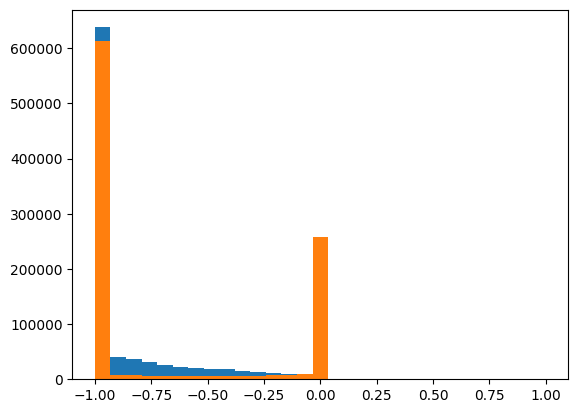

In [145]:
min_val = -1
max_val = 1

# array of bin edges
bins = np.linspace(min_val, max_val, 30)  # 
# plt.hist(df.bid_model, bins=bins)

df['bid_effect_model'] = df.bid_model * df.bid_size_model
df['ask_effect_model'] = df.ask_model * df.ask_size_model
plt.hist(df.bid_effect_model, bins=bins)
plt.hist(df.ask_effect_model, bins=bins)


In [71]:
# Tuning rewards

df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/tune_multiple_val_envs_csv.csv")

reward_col = ["trial_reward"]
interesting_cols = ['max_inventory','sharpe'] 
parameter_cols = ['n_steps', 'batch_size', 'gae_lambda', 'gamma', 'learning_rate', 'max_grad_norm', 'vf_coef', 'ent_coef', 'clip_range', 'clip_range_vf', 'n_epochs', 'normalize_advantage', 'sde_sample_freq']


df['trial_reward'].sort_values()

495    0.000000
199    0.000000
498    0.000000
204    0.000000
497    0.000000
         ...   
301    2.563640
816    2.682756
161    2.715703
837    2.795789
911    5.003991
Name: trial_reward, Length: 920, dtype: float64

In [ ]:
# FIX HEADERS

# correct_headers = ["timestamp", "best_bid", "best_ask", "mid_price", "low_price", 
#                    "high_price", "order_book_imbalance", "current_second", 
#                    "current_minute", "current_hour", "intensity", "volatility", "osi"]

# # Specify the directory where the CSV files are
# dir_name = "/Volumes/ssd/gradu_data/parsed"
# for root, _, files in os.walk(dir_name):
#     for file in files:
#         if 'base' in file or 'interim' in file:
#             continue
#         # Check if the file is a CSV file
#         if file.endswith(".csv") and not file.startswith("._"):
#             print(root,file)
#             file_path = os.path.join(root, file)

#             # Read the CSV file, skip the first row
#             df = pd.read_csv(file_path, header=None, skiprows=1)

#             # Assign the correct headers
#             df.columns = correct_headers

#             # Write the dataframe back to the CSV file
#             df.to_csv(file_path, index=False)